# Training Potts Models with Contrastive Divergence for Protein Design

In [ ]:
!git clone https://github.com/igemto-drylab/CSBERG-ML.git
%cd CSBERG-ML
from util import *
import tqdm.notebook as tq
%cd ..

/content/CSBERG-ML
/content


In [ ]:
plt.rcParams['figure.dpi'] = 350

### GREMLIN

https://github.com/whbpt/GREMLIN_PYTORCH/blob/master/GREMLIN_pytorch.ipynb

Also see https://github.com/HussainAther/potts/blob/main/notebooks/CSC412_Potts_Proteins_hussain.ipynb

In [ ]:
msa = read_fasta("/content/lcc_short.fasta")
print(msa.shape)
N, L, A = msa.shape

torch.Size([15028, 227, 21])


In [ ]:
class GREMLIN(torch.nn.Module):
  def __init__(self,L,A):
    super(GREMLIN, self).__init__()
    self.W0 = torch.nn.Parameter(torch.zeros(L*A,L*A), requires_grad=True)
    self.b0 = torch.nn.Parameter(torch.zeros(L*A), requires_grad=True)
    self.MASK = (1.0 -torch.eye(L*A)).to(device)


  def forward(self, X):
    X = X.reshape(-1,L*A)
    W = (self.W0+self.W0)/2.0 * self.MASK
   
    MSA_pred = (X.mm(W)+self.b0).reshape(-1,L,A)
    loss = torch.sum(- msa * F.log_softmax(MSA_pred, -1))
    L2_w = torch.square(W).sum() * 0.01 * 0.5 *L*A
    L2_b = torch.square(self.b0).sum() * 0.01
    loss = loss + L2_w + L2_b
    return loss

In [ ]:
class Model(torch.nn.Module):
  def __init__(self,L,A):
    super(Model, self).__init__()
    self.GREMLIN_ = GREMLIN(L,A)
    
  def forward(self,X):
    loss = self.GREMLIN_(X)
    return loss

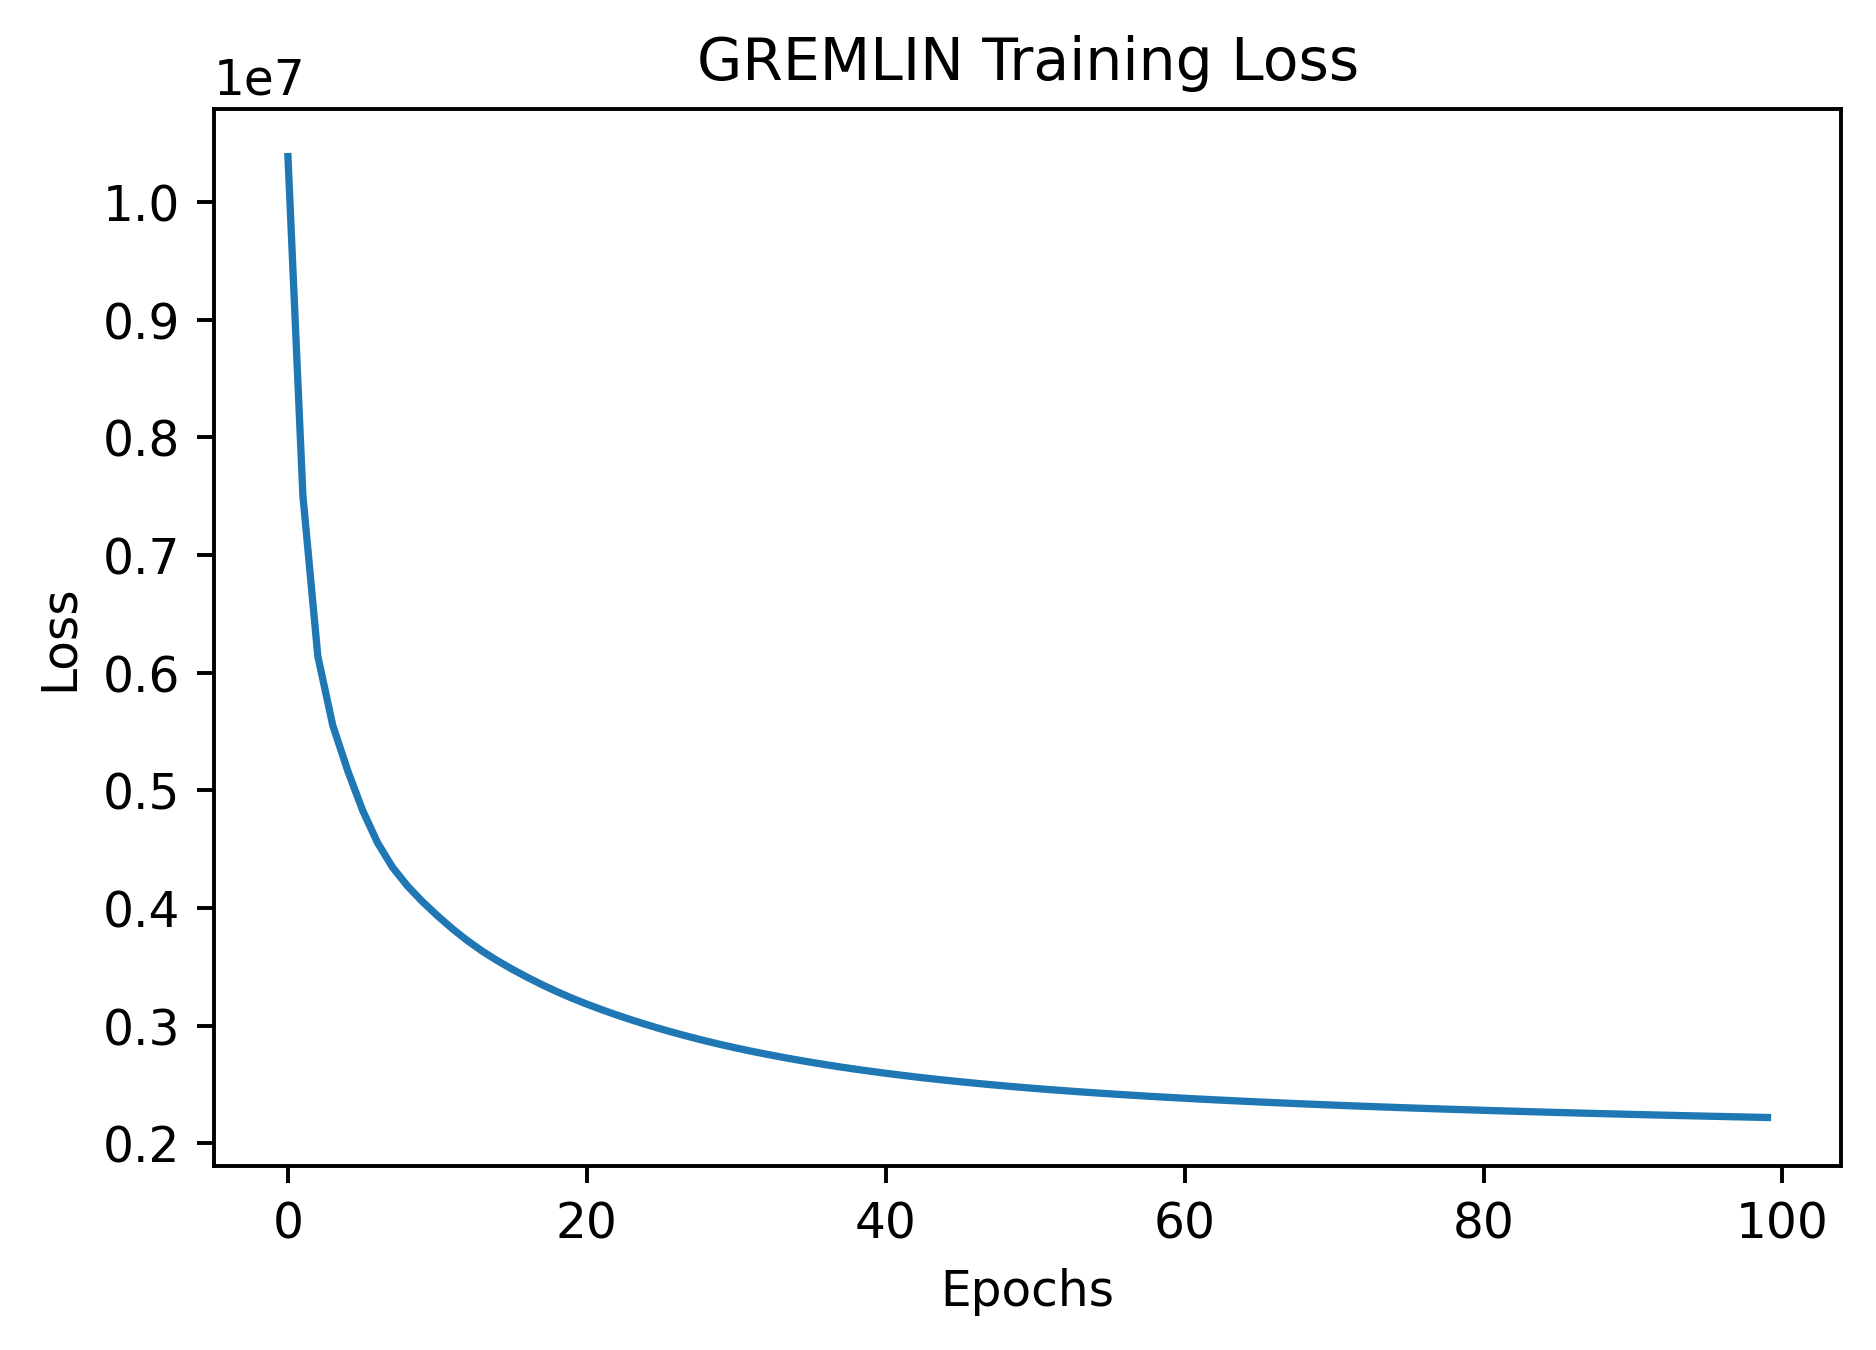

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model(L,A).to(device)
learning_rate = 0.1*np.log(N)/L
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
msa = msa.type(torch.FloatTensor).to(device)

losses = []
for t in tq.tqdm(range(100)):
    loss = model(msa)      
    optimizer.zero_grad()    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())

plt.plot(losses)
plt.title("GREMLIN Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
w = model.GREMLIN_.W0.cpu().detach().numpy()
w = (w+w.T).reshape(L,A,L,A)
h = model.GREMLIN_.b0.cpu().detach().numpy()
np.save("gremlin_h_lcc.npy", h)
np.save("gremlin_J_lcc.npy", w)

Direct coupling analysis to get contact predictions

In [ ]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:,:,:]),(1,3)))
  np.fill_diagonal(raw,0)
  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

In [ ]:
w.shape

(227, 21, 227, 21)

In [ ]:
 def get_contacts(w, showContacts=True):
    """
    w:            (L, 21, L, 21) numpy array corresponding to the J parameter
    showContacts: When True, shows the couplings matrix before and after APC
    """
    raw, apc = get_mtx(w)
    raw_copy = np.copy(raw)
    apc_copy = np.copy(apc)
    for i in range(len(apc)):
        for j in range(len(apc)):
            if abs(i-j) < 7:
                apc_copy[i,j] = 0
                raw_copy[i,j] = 0
    if showContacts:
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(raw_copy)
        plt.grid(False)
        plt.title("Before APC")
        plt.xlabel("Residue Index")
        plt.ylabel("Residue Index")
        plt.subplot(1,2,2)
        plt.imshow(apc_copy)
        plt.xlabel("Residue Index")
        plt.grid(False)
        plt.title("After APC")
        plt.show()
    apc_copy = (apc_copy - np.min(apc_copy))/(np.max(apc_copy) - np.min(apc_copy))
    strengths = {}
    for i in range(len(apc)):
        for j in range(i, len(apc)):
            strengths[(i,j)] = apc_copy[i,j] 
    contacts = list(strengths.keys())
    contacts = sorted(contacts, key=lambda x: strengths[x], reverse=True)
    for i in range(len(contacts)):
        contacts[i] = list(contacts[i])
    L_2 = np.array(contacts[:int(len(apc) / 2)])    # @L/2
    L_5 = np.array(contacts[:int(len(apc) / 5)])    # @L/5
    return L_2, L_5

In [ ]:
L2, L5 = get_contacts(w, showContacts=False)

#### Likelihoods

In [ ]:
# random model
model = Model(L,A).to(device)

In [ ]:
h = model.GREMLIN_.b0.detach()
J = model.GREMLIN_.W0.detach()
J = (J + J.T)

In [ ]:
in_dist = get_numerical_aas("lcc_short.fasta")
out_dist1 = torch.from_numpy(np.array([np.random.permutation(s) for s in in_dist])).to(device)
out_dist2 = torch.from_numpy(np.array([np.concatenate((s[int(L/2):], s[:int(L/2)])) for s in in_dist])).to(device)
in_dist = torch.from_numpy(in_dist).to(device)

in_ratios = []
out_ratios = []
in_out1_ratios = []
in_out2_ratios = []
for i in tq.tqdm(range(200)):
    in_out1_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist1[i], h, J).item())
    in_out2_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist2[i], h, J).item())
    in_ratios.append(logE(in_dist[i], h, J).item() - logE(in_dist[i+1], h, J).item())
    out_ratios.append(logE(out_dist1[i], h, J).item() - logE(out_dist1[i+1], h, J).item())

import seaborn as sns

sns.kdeplot(in_ratios, label = "In/In")
sns.kdeplot(out_ratios, label = "Out/Out")
sns.kdeplot(in_out1_ratios, label = "In/Out1")
sns.kdeplot(in_out2_ratios, label = "In/Out2")

plt.legend()
# plt.title('GREMLIN')
plt.title("Random")
plt.xlabel('Log Ratio of Energies')
plt.ylabel('Density')

NameError: ignored

Estimate overlap between In/Out2 and In/In using 

https://stackoverflow.com/a/62375969

In [ ]:
from scipy.stats import gaussian_kde

def get_fp(inin, inout):
    """
    Returns the false positive score as the overlapping area of the 
    In/Out vs. In/In distributions
    """
    x0 = np.array(inout)
    x1 = np.array(inin)
    kde0 = gaussian_kde(x0, bw_method=0.3)
    kde1 = gaussian_kde(x1, bw_method=0.3)

    xmin = min(x0.min(), x1.min())
    xmax = max(x0.max(), x1.max())
    dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
    xmin -= dx
    xmax += dx

    x = np.linspace(xmin, xmax, 500)
    kde0_x = kde0(x)
    kde1_x = kde1(x)
    inters_x = np.minimum(kde0_x, kde1_x)

    print("False positive score: ", np.trapz(inters_x, x)/np.trapz(kde1_x, x))

In [ ]:
get_fp(in_ratios, in_out2_ratios)

False positive score:  0.008474580017738492


#### Correlations

In [ ]:
def save_gremlin(model):
    """
    Saves GREMLIN model parameters h and J as a .txt file with the same format
    as parameters.txt in bmDCA
    """
    J = model.GREMLIN_.W0.cpu().detach().numpy()
    J = (J+J.T)
    h = model.GREMLIN_.b0.cpu().detach().numpy()
    h_txt = ""
    J_txt = ""
    for i in range(L):
        for aa in range(21):
            h_txt += "h {} {} {}\n".format(i, aa, h[i*21 + aa])
    for i in tq.tqdm(range(L)):
        for j in range(i+1, L):
            for aa1 in range(21):
                for aa2 in range(21):
                    J_txt += "J {} {} {} {} {}\n".format(i, j, aa1, aa2, 
                                                                 J[i*21 + aa1, j*21 + aa2])
    with open("parameters.txt", 'w') as f:
        f.write(J_txt)
        f.write(h_txt)

In [ ]:
save_gremlin(model)

In [ ]:
%%shell
bmdca_sample -p /content/parameters.txt \
             -d /content -o samples.txt -n 1000 -r 10

initializing sampler... 4.24231 sec

sampling model with mcmc... 45.1125 sec
updating mcmc stats with samples... 3.8221 sec
computing sequence energies and correlations... 0.319666 sec
increasing wait time to 1500
resampling...
writing temporary files
sampling model with mcmc... 65.7212 sec
updating mcmc stats with samples... 3.82478 sec
computing sequence energies and correlations... 0.30928 sec
increasing wait time to 2250
resampling...
writing temporary files
sampling model with mcmc... 96.729 sec
updating mcmc stats with samples... 3.83913 sec
computing sequence energies and correlations... 0.307709 sec
increasing wait time to 3375
resampling...
writing temporary files
sampling model with mcmc... 144.062 sec
updating mcmc stats with samples... 3.81957 sec
computing sequence energies and correlations... 0.304504 sec
increasing wait time to 5063
resampling...
writing temporary files
sampling model with mcmc... 210.946 sec
updating mcmc stats with samples... 3.8343 sec
computing seque

CalledProcessError: ignored

In [ ]:
samples = read_fasta("temp_samples.txt")
xin = read_fasta("lcc_short.fasta")
# first_order(xin, samples)


Spearman:  0.00022852192037139772


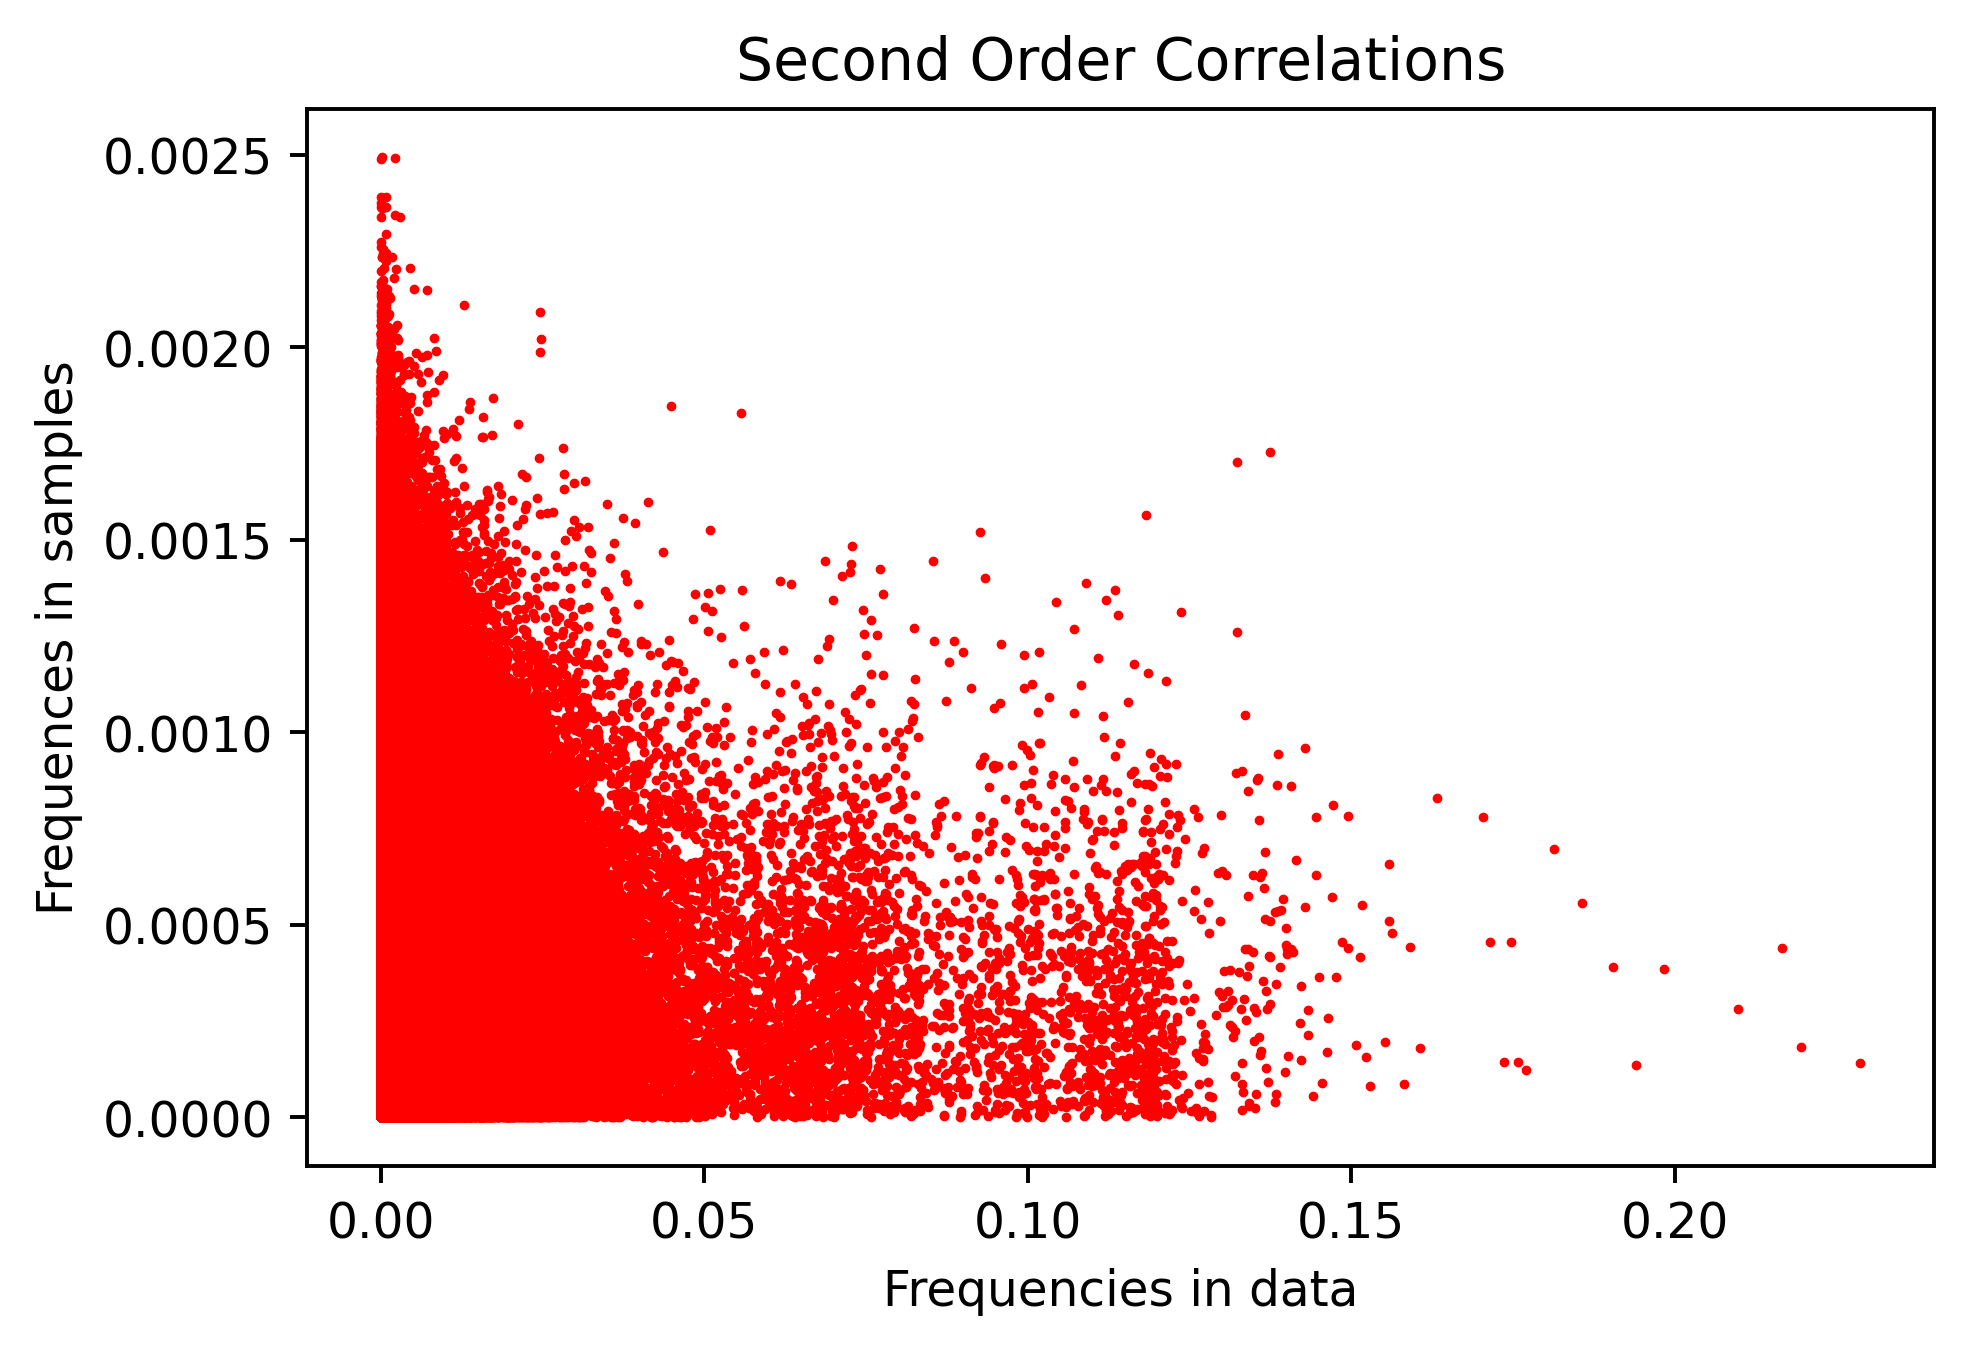

In [ ]:
freqs_data, freqs_samp = second_order(xin, samples)

import itertools

freqs_data_flat = list(itertools.chain.from_iterable(freqs_data))
freqs_samp_flat = list(itertools.chain.from_iterable(freqs_samp))

print("Spearman: ", stats.pearsonr(freqs_data_flat, freqs_samp_flat)[0])
plt.scatter(freqs_data_flat, freqs_samp_flat, s=1, c='red')
plt.title("Second Order Correlations")
plt.xlabel("Frequencies in data")
plt.ylabel("Frequences in samples")
plt.show()

#### Sequence Identity

In [ ]:
idents_gremlin = seq_identity(xin, samples)
# plt.hist(idents, alpha=0.3)
# plt.xlabel("Sequence Identity")
# plt.ylabel("Frequency")
# plt.title("Sequence Identities of Samples")
# plt.show()

### bmDCA

**Important Notes:**

*  All amino acids must be upper case

https://github.com/ranganathanlab/bmDCA

In [ ]:
!git clone https://github.com/ranganathanlab/bmDCA.git

Cloning into 'bmDCA'...
remote: Enumerating objects: 1679, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1679 (delta 15), reused 22 (delta 10), pack-reused 1646
Receiving objects: 100% (1679/1679), 790.26 KiB | 16.46 MiB/s, done.
Resolving deltas: 100% (1152/1152), done.


In [ ]:
!sudo apt-get update
!sudo apt-get install git gcc g++ automake autoconf pkg-config \
  libarmadillo-dev libopenblas-dev libarpack++2-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [694 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 http://pp

In [ ]:
%cd bmDCA
!bash autogen.sh --prefix=/usr/local && \
%cd ..

/content/bmDCA
configure.ac:8: installing './config.guess'
configure.ac:8: installing './config.sub'
configure.ac:35: installing './install-sh'
configure.ac:35: installing './missing'
src/Makefile.am: installing './depcomp'
+ ./configure --prefix=/usr/local
checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking whether to enable maintainer-specific portions of Makefiles... yes
checking whether make supports nested variables... (cached) yes
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we ar

In [ ]:
%%shell
cd bmDCA
make -j4 && \
make install
cd ..

/bin/bash: line 0: cd: bmDCA: No such file or directory
Making all in src
make[1]: Entering directory '/content/bmDCA/src'
  CXX      bmdca.o
  CXX      msa_stats.o
  CXX      msa.o
  CXX      model.o
  CXX      run.o
  CXX      mcmc.o
  CXX      mcmc_stats.o
  CXX      graph.o
  CXX      utils.o
run.cpp: In constructor ‘Sim::Sim(MSAStats, std::__cxx11::string, std::__cxx11::string, bool)’:
run.cpp:383:10: warning: ignoring return value of ‘int chdir(const char*)’, declared with attribute warn_unused_result [-Wunused-result]
     chdir(dest_dir.c_str());
     ~~~~~^~~~~~~~~~~~~~~~~~
  CXX      bmdca_sample.o
  CXX      generator.o
  CXX      arma_convert.o
bmdca_sample.cpp: In function ‘int main(int, char**)’:
bmdca_sample.cpp:124:10: warning: ignoring return value of ‘int chdir(const char*)’, declared with attribute warn_unused_result [-Wunused-result]
     chdir(dest_dir.c_str());
     ~~~~~^~~~~~~~~~~~~~~~~~
  CXX      fasta_convert.o
  CXXLD    bmdca_sample
  CXXLD    bmdca
  CXXLD

In [ ]:
%cd /content

/content


#### Training

In [ ]:
def read_fasta(fname, onehot=True):
    seqs = []
    seq_list = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    seqs.append(s)
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
        seqs.append(s)
        seq_list.append(list(s))
    if onehot:
        return get_X(seqs)
    else:
        return np.array(seqs)

def read_fasta_seqs(fname):
    seqs = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    seqs.append(list(s))
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
        seqs.append(list(s))
    return np.array(seqs)

In [ ]:
def trim_seqs(seqs, save_name):
    """
    seqs: sequences (list of letters not one-hot encoded)
    save_name: output fasta filename
    returns: mask (1 for kept positions, 0 for discarded positions)
    """
    mask = np.zeros(len(seqs[0]), dtype=np.bool)
    for i in range(len(seqs[0])):
        gaps = 0
        for s in seqs:
            if s[i] == '-':
                gaps += 1
        if gaps/len(seqs) < 0.67:   # keep positions where less than 2/3rd are gaps
            mask[i] = True
    seqs = seqs[:,mask]

    towrite = ""
    for i in range(len(seqs)):
        if sum(seqs[i][100:] == "-") < 50:  # don't take sequences with many gaps
            towrite += ">{}\n".format(i)
            seq = "".join(seqs[i][:]) + "\n"
            towrite += seq.upper()   
    with open(save_name,'w') as f:
        f.write(towrite)
    return mask

In [ ]:
seqs = read_fasta_seqs("/content/lcc_pfam.txt")
mask = trim_seqs(seqs, "lcc_short.fasta")

In [ ]:
i = 0
j = 0
trim2ali = {}    # maps index of trimmed sequence to index of aligned sequence
while j < len(mask):
    if mask[j] == 1:
        trim2ali[i] = j
        i += 1
    j += 1
print(trim2ali)

{0: 165, 1: 166, 2: 167, 3: 168, 4: 169, 5: 170, 6: 172, 7: 173, 8: 174, 9: 175, 10: 177, 11: 179, 12: 181, 13: 182, 14: 183, 15: 184, 16: 192, 17: 193, 18: 194, 19: 195, 20: 197, 21: 200, 22: 205, 23: 213, 24: 221, 25: 231, 26: 241, 27: 250, 28: 260, 29: 269, 30: 271, 31: 272, 32: 290, 33: 291, 34: 295, 35: 299, 36: 304, 37: 309, 38: 317, 39: 322, 40: 328, 41: 338, 42: 345, 43: 351, 44: 360, 45: 366, 46: 379, 47: 389, 48: 392, 49: 396, 50: 404, 51: 414, 52: 418, 53: 427, 54: 431, 55: 435, 56: 439, 57: 440, 58: 441, 59: 502, 60: 503, 61: 505, 62: 509, 63: 513, 64: 517, 65: 520, 66: 524, 67: 529, 68: 534, 69: 540, 70: 545, 71: 551, 72: 561, 73: 569, 74: 574, 75: 583, 76: 591, 77: 598, 78: 608, 79: 617, 80: 626, 81: 633, 82: 641, 83: 648, 84: 652, 85: 656, 86: 659, 87: 660, 88: 694, 89: 698, 90: 702, 91: 706, 92: 710, 93: 716, 94: 722, 95: 730, 96: 737, 97: 744, 98: 751, 99: 759, 100: 769, 101: 783, 102: 798, 103: 809, 104: 816, 105: 822, 106: 829, 107: 832, 108: 836, 109: 838, 110: 848,

In [ ]:
# map index of aligned sequence to residue index on the protein structure
aligned = """------------------------------------------------------------
------------------------------------------------------------
-----------------------------------------------AGTV------Y-Y
-PTNAG------GTVG-A--I----A-------I-------V---------P--------
-G--------Y---------T--------A-RQ-----------------SS---I---K
----W----W-------G----P-----R---------L------A-----S--------
H-----G------------F---------V--V---I-------T---------I---D-
-------T---N---S---TLD--------------------------------------
----------------------QP-S---S---R---S--S---Q----Q----M-----
A----A-----L---------R-------Q----V--------A-------S------L-
--------N---------------------------------------G---T---S--S
S-----------------------------------------------------------
----------P------I------Y------G-------K---------V----------
---D--------------T----------A------R-----M------G--V---M-G-
--------W---S-------M-----------G--------G---------G------G-
--------S-----------L-------------I-----------S-------------
---A----------------A---------------N---------------N-------
--P---------------S---------------L--------------K----------
--A----------A-------------A---------P---------Q------A-P---
------------------------------------------------------------
---W--D--S-----S----T-----N-----F------S-----S------V-------
-T--------V------P-----T-------L---I-----F--A-C---E--N------
--D--S---I---A--P----V---N--S------------------------S-A-L--
-PI--------Y-------D--------S------M--------------------S---
-------R------------------N-----------A----------K----------
Q------F--------L-------------------------------------------
------------------------------------------------------------
------------------------------------------------------------
-----------------EINGGSHSCANSGNSNQALIGKKGVAWMKRFM-----------
------------------------------------------------------------
--------------------------------""".replace('\n','')

short = """--AGTV----YYPTNAGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVV
ITIDTNSTLDQPSSRSSQQMAALRQVASLN----GTSSS-------PIYGKVDTARMGVM
GWSMGGGGSLISAANNPSLKAAAPQAP---WDSSTNFSSVTVPTLIFACENDSIAPVNSS
ALIYDSM-SRNAKQFL---------------------------------------EIN""".replace('\n','')

protein = """MNFPRASRLMQAAVLGGLMAVSAAATAQTNPYARGPNPTAASLEASAGPFTVRSFTVSRPS
GYGAGTVYYPTNAGGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPS
SRSSQQMAALRQVASLNGTSSSPIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAP
QAPWDSSTNFSSVTVPTLIFACENDSIAPVNSSALPIYDSMSRNAKQFLEINGGSHSCAN
SGNSNQALIGKKGVAWMKRFMDNDTRYSTFACENPNSTRVSDFRTANCSLEHHHHHH""".replace('\n','')

ali2prot = {}
i = 0
j = 65 - 1
while i < len(aligned):
    if aligned[i] != "-":
        if aligned[i] == protein[j]:
            ali2prot[i] = j + 1
            j += 1
        else:
            raise KeyError
    i += 1
print(ali2prot)

{167: 65, 168: 66, 169: 67, 170: 68, 177: 69, 179: 70, 181: 71, 182: 72, 183: 73, 184: 74, 185: 75, 192: 76, 193: 77, 194: 78, 195: 79, 197: 80, 200: 81, 205: 82, 213: 83, 221: 84, 231: 85, 241: 86, 250: 87, 260: 88, 269: 89, 271: 90, 272: 91, 290: 92, 291: 93, 295: 94, 299: 95, 304: 96, 309: 97, 317: 98, 322: 99, 328: 100, 338: 101, 345: 102, 351: 103, 360: 104, 366: 105, 379: 106, 389: 107, 392: 108, 396: 109, 404: 110, 414: 111, 418: 112, 427: 113, 431: 114, 435: 115, 439: 116, 440: 117, 441: 118, 502: 119, 503: 120, 505: 121, 509: 122, 513: 123, 517: 124, 520: 125, 524: 126, 529: 127, 534: 128, 540: 129, 545: 130, 551: 131, 561: 132, 569: 133, 574: 134, 583: 135, 591: 136, 598: 137, 608: 138, 648: 139, 652: 140, 656: 141, 659: 142, 660: 143, 730: 144, 737: 145, 744: 146, 751: 147, 759: 148, 769: 149, 783: 150, 798: 151, 809: 152, 816: 153, 822: 154, 829: 155, 832: 156, 836: 157, 838: 158, 848: 159, 852: 160, 860: 161, 872: 162, 881: 163, 891: 164, 898: 165, 908: 166, 920: 167, 934:

In [ ]:
idx = np.array(list(trim2ali.values())).astype(np.int)
ali = np.array(list(aligned))
print("".join(list(ali[idx])))

--AGTV----YYPTNAGTVGAIAIVPGYTARQSSIKWWGPRLASHGFVVITIDTNSTLDQPSSRSSQQMAALRQVASLN----GTSSS-------PIYGKVDTARMGVMGWSMGGGGSLISAANNPSLKAAAPQAP---WDSSTNFSSVTVPTLIFACENDSIAPVNSSALIYDSM-SRNAKQFL---------------------------------------EIN


In [ ]:
def map_index(l):
    """
    l: list of indices of the trimmed sequences
    returns: corresponding protein structure indices
    """
    idx = []
    for i in l:
        try:
            idx.append(ali2prot[trim2ali[i]])
        except KeyError:
            idx.append(0)
    return idx

Evaluate precision metric for contact prediction

In [ ]:
beta_carbons = []
with open("/content/CSBERG-ML/1gfp_h.pdb", 'r') as f:
    line = f.readline()
    line = f.readline()
    while line:
        data = line.split()
        if data[2] == 'CB' or data[2] == 'HA1':
            beta_carbons.append([float(data[6]), float(data[7]), float(data[8])])
        line = f.readline()

coords = np.array(beta_carbons[1:])

dists = np.zeros((len(coords), len(coords)))
for i, curr in enumerate(coords):
    dists[:,i] = np.linalg.norm(coords - curr, axis=1)

In [ ]:
def get_precision(L2, L5):
    for l in [L2, L5]:
        p = 0
        a = map_index(list(l.flatten()))
        a = np.array(a).reshape(-1,2) - 29  # structure index starts at 29
        for row in a:
            if row[0] != 0 and row[1] != 0:
                if dists[row[0], row[1]] < 8.0:
                    p += 1
        print(p/len(L2))

In [ ]:
%%shell
rm results/*
bmdca -i lcc_short.fasta -r -d /content/results

15047 sequences
227 positions
21 amino acids (including gaps)
9318.1 effective sequences
initializing run... 5.29271 sec

Step: 1
sampling model with mcmc... 7.80018 sec
updating mcmc with samples... 4.8794 sec
computing sequence energies and correlations... 0.3637 sec
computing mcmc 1p and 2p statistics... 2.44098 sec
computing error and updating gradient... 1.53069 sec
update learning rate... 0.227634 sec
updating parameters... 0.230206 sec

Step: 2
sampling model with mcmc... 7.64549 sec
updating mcmc with samples... 4.84465 sec
computing sequence energies and correlations... 0.370797 sec
computing mcmc 1p and 2p statistics... 2.48229 sec
computing error and updating gradient... 1.54458 sec
update learning rate... 0.223336 sec
updating parameters... 0.220518 sec

Step: 3
sampling model with mcmc... 7.638 sec
updating mcmc with samples... 4.85864 sec
computing sequence energies and correlations... 0.367031 sec
computing mcmc 1p and 2p statistics... 2.4813 sec
computing error and upda

In [ ]:
!tar -czf boltzmann.tar.gz results/*

#### Sampling

Sample 1000*10 sequences

In [ ]:
%%shell
bmdca_sample -p /content/parameters_h_60.bin -P /content/parameters_J_60.bin \
             -d /content -o samples.txt -n 1000 -r 10

initializing sampler... 4.27407 sec

sampling model with mcmc... 46.8994 sec
updating mcmc stats with samples... 3.89151 sec
computing sequence energies and correlations... 0.314066 sec
increasing burn-in time to 150000
resampling...
writing temporary files
sampling model with mcmc... 49.0608 sec
updating mcmc stats with samples... 3.87549 sec
computing sequence energies and correlations... 0.309144 sec
writing final sequences... done


In [ ]:
%%shell
bmdca_sample -p /content/parameters.txt \
             -d /content -o samples.txt -n 1000 -r 10

Convert numeric samples into FASTA sequences

In [ ]:
# this AA to IDX mapping is specifically for bmDCA
AA = list("-ACDEFGHIKLMNPQRSTVWY")
AA_IDX = {AA[i]:i for i in range(len(AA))}
IDX_AA = {i:AA[i].upper() for i in range(len(AA))}

def int2fasta(in_name, out_name):
    """
    in_name: filename of samples as outputed from bmDCA
    out_name: name of fasta file output
    """
    towrite = ""

    with open(in_name, 'r') as f:
        line = f.readline()
        line = f.readline()
        id = 1
        while line:
            aanums = line.split()
            seqlist = [IDX_AA[int(aa)] for aa in aanums]
            towrite += ">{}\n".format(id)
            towrite += "".join(seqlist) + "\n"
            line = f.readline()
            id += 1

    with open(out_name, 'w') as f:
        f.write(towrite)

# int2fasta("/content/MC_samples_60.txt", "samples.fasta")

#### Likelihoods

Doesn't come with a function, so implement it ourselves by using the learned parameters $\mathbf{h}, \mathbf{J}$.

In [ ]:
L = 227   # sequence length
q = 21  # number of tokens  (this is 'A' in the GREMLIN code)

h = torch.from_numpy(np.random.randn(L*q))           # fields    (this is b0 in GREMLIN)
J = torch.from_numpy(np.random.randn(L*q, L*q))      # couplings (this is W0 in GREMLIN)


# compute the energy logexp(.) for a sequence s

def logE(s, h, J):
    """
    s: sequence
    h: fields vector (L*q)
    J: couplings matrix (L*q, L*q)
    """
    # compute indicies of s by adding to it [0, 0, 0, ... 21, 21, 21 ...]
    if not torch.is_tensor(s):
        s = torch.from_numpy(s)
    # print(s)
    # print(torch.linspace(0, q*(L-1), L))
    s_idx = s + torch.linspace(0, q*(L-1), L).type(torch.LongTensor).to(device)
    sum_h = torch.sum(h[s_idx])
    j_idx = torch.meshgrid(s_idx, s_idx)
    sum_J = torch.sum(J[j_idx])
    return -(sum_h + sum_J)

# convert list of M sequences of length L each into an MxL matrix of numbers in [0,20]

def seq2num(s):
    nums = []
    for aa in s:
        try:
            nums.append(AA_IDX[aa.upper()])
        except KeyError:
            return None
    return nums

def get_numerical_aas(fname):
    mat = []
    s = ""
    with open(fname) as f:
        line = f.readline()
        while line:
            if line.startswith(">"):
                if s != "":
                    aanums = seq2num(s)
                    if aanums is not None:
                        mat.append(aanums)
                s = ""
            elif len(line) > 0:
                s += line.strip()
            line = f.readline()
    return np.array(mat)

Get the in-distribution sequences (this is just the training data)

In [ ]:
import numpy as np

in_dist = get_numerical_aas("lcc_short.fasta")

Get the out-of-distribution sequences. We construct these sequences in the following ways:



*   Let $S$ be an in-distribution sequence. We take $S'$ to be the shuffled $S$ which is likely out-of-distribution.
*   Let $S=S_1S_2$ be an in-distribution sequence. We assume that $S''=S_2S_1$ is out-of-distribution. This corresponds to swapping the two ends of the protein chain which is likely to disrupt the protein fold.



In [ ]:
out_dist1 = np.array([np.random.permutation(s) for s in in_dist])

In [ ]:
out_dist2 = np.array([np.concatenate((s[int(L/2):], s[:int(L/2)])) for s in in_dist])

Compute $\log \frac{P(S)}{P(S')}$

In [ ]:
in_ratios = []
out_ratios = []
in_out1_ratios = []
in_out2_ratios = []
for i in tq.tqdm(range(200)):
    in_out1_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist1[i], h, J).item())
    in_out2_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist2[i], h, J).item())
    in_ratios.append(logE(in_dist[i], h, J).item() - logE(in_dist[i+1], h, J).item())
    out_ratios.append(logE(out_dist1[i], h, J).item() - logE(out_dist1[i+1], h, J).item())

Text(0, 0.5, 'Density')

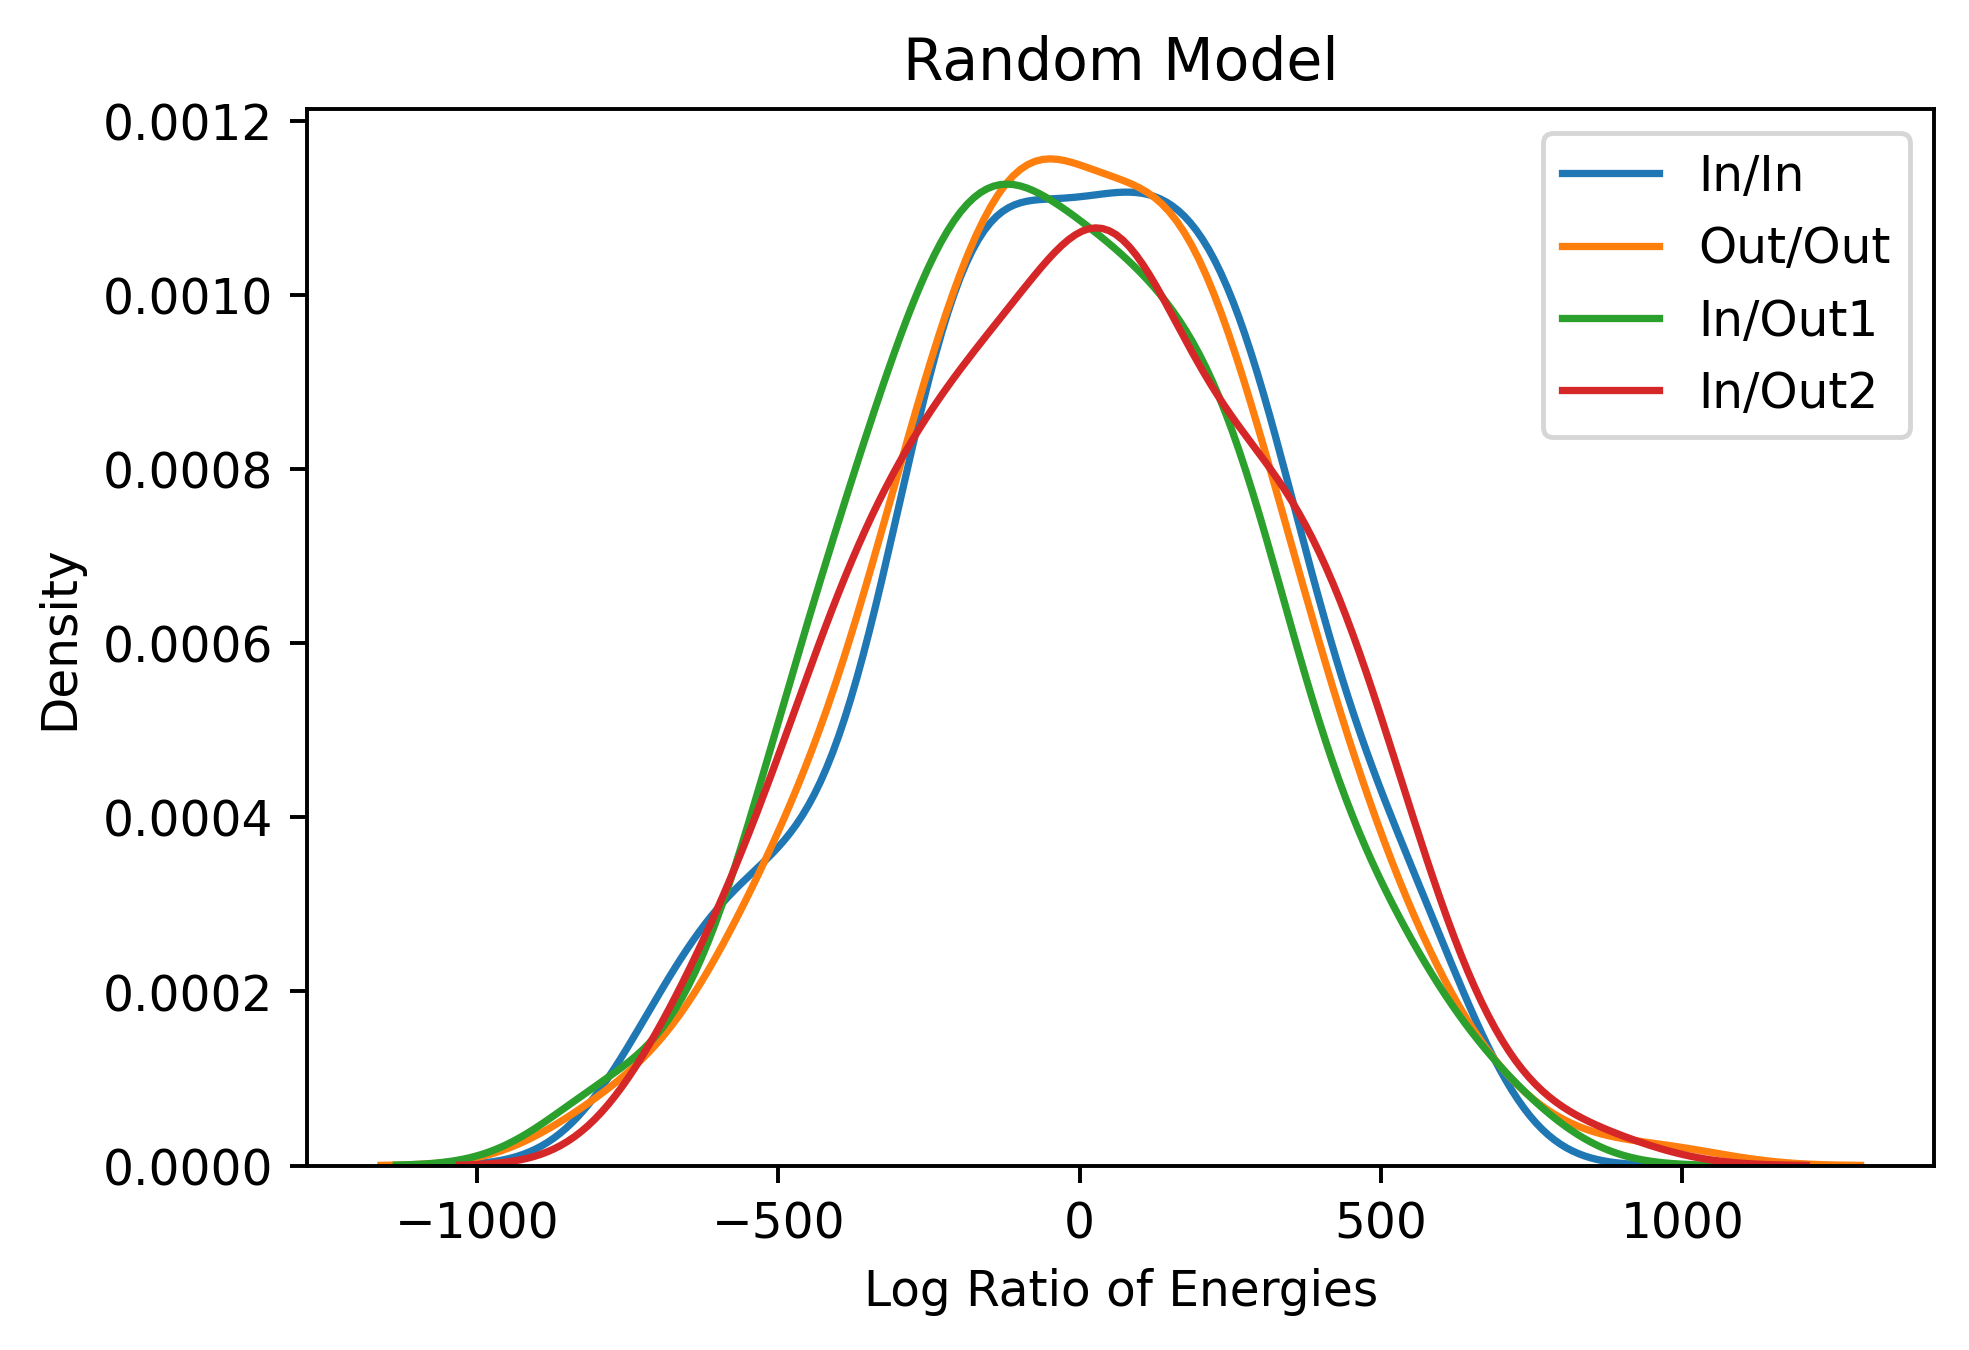

In [ ]:
import seaborn as sns

sns.kdeplot(in_ratios, label = "In/In")
sns.kdeplot(out_ratios, label = "Out/Out")
sns.kdeplot(in_out1_ratios, label = "In/Out1")
sns.kdeplot(in_out2_ratios, label = "In/Out2")

plt.legend()
plt.title('Random Model')
plt.xlabel('Log Ratio of Energies')
plt.ylabel('Density')

In [ ]:
get_fp(in_ratios, in_out2_ratios)

False positive score:  0.9303067671796886


Load the $\mathbf{h}, \mathbf{J}$ from bmDCA (took 12 hours to train)

In [ ]:
%%shell
arma2ascii -p parameters_h_60.bin -P parameters_J_60.bin

converting 'parameters_h_60.bin' and 'parameters_J_60.bin' to text... done


Convert parameters from .txt file to numpy arrays

J [position index i] [position index j] [amino acid index a] [amino acid index b]
.
.
.


h [position index i] [amino acid index a]
.
.
.

In [ ]:
h = np.random.randn(L*q)           # fields    (this is b0 in GREMLIN)
J = np.random.randn(L*q, L*q)      # couplings (this is W0 in GREMLIN)

with open("parameters_60.txt", 'r') as f:
    line = f.readline()
    while line:
        data = line.strip().split()
        if data[0] == 'J':
            i, j, aa1, aa2 = int(data[1]), int(data[2]), int(data[3]), int(data[4])
            J[i*q + aa1, j*q + aa2] = float(data[-1])
        if data[0] == 'h':
            i, aa = int(data[1]), int(data[2])
            h[i*q + aa] = float(data[-1])
        line = f.readline()

In [ ]:
in_ratios = []
out_ratios = []
in_out1_ratios = []
in_out2_ratios = []
h = torch.from_numpy(h)
J = torch.from_numpy(J)
for i in tq.tqdm(range(200)):
    in_out1_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist1[i], h, J).item())
    in_out2_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist2[i], h, J).item())
    in_ratios.append(logE(in_dist[i], h, J).item() - logE(in_dist[i+1], h, J).item())
    out_ratios.append(logE(out_dist1[i], h, J).item() - logE(out_dist1[i+1], h, J).item())

Text(0, 0.5, 'Density')

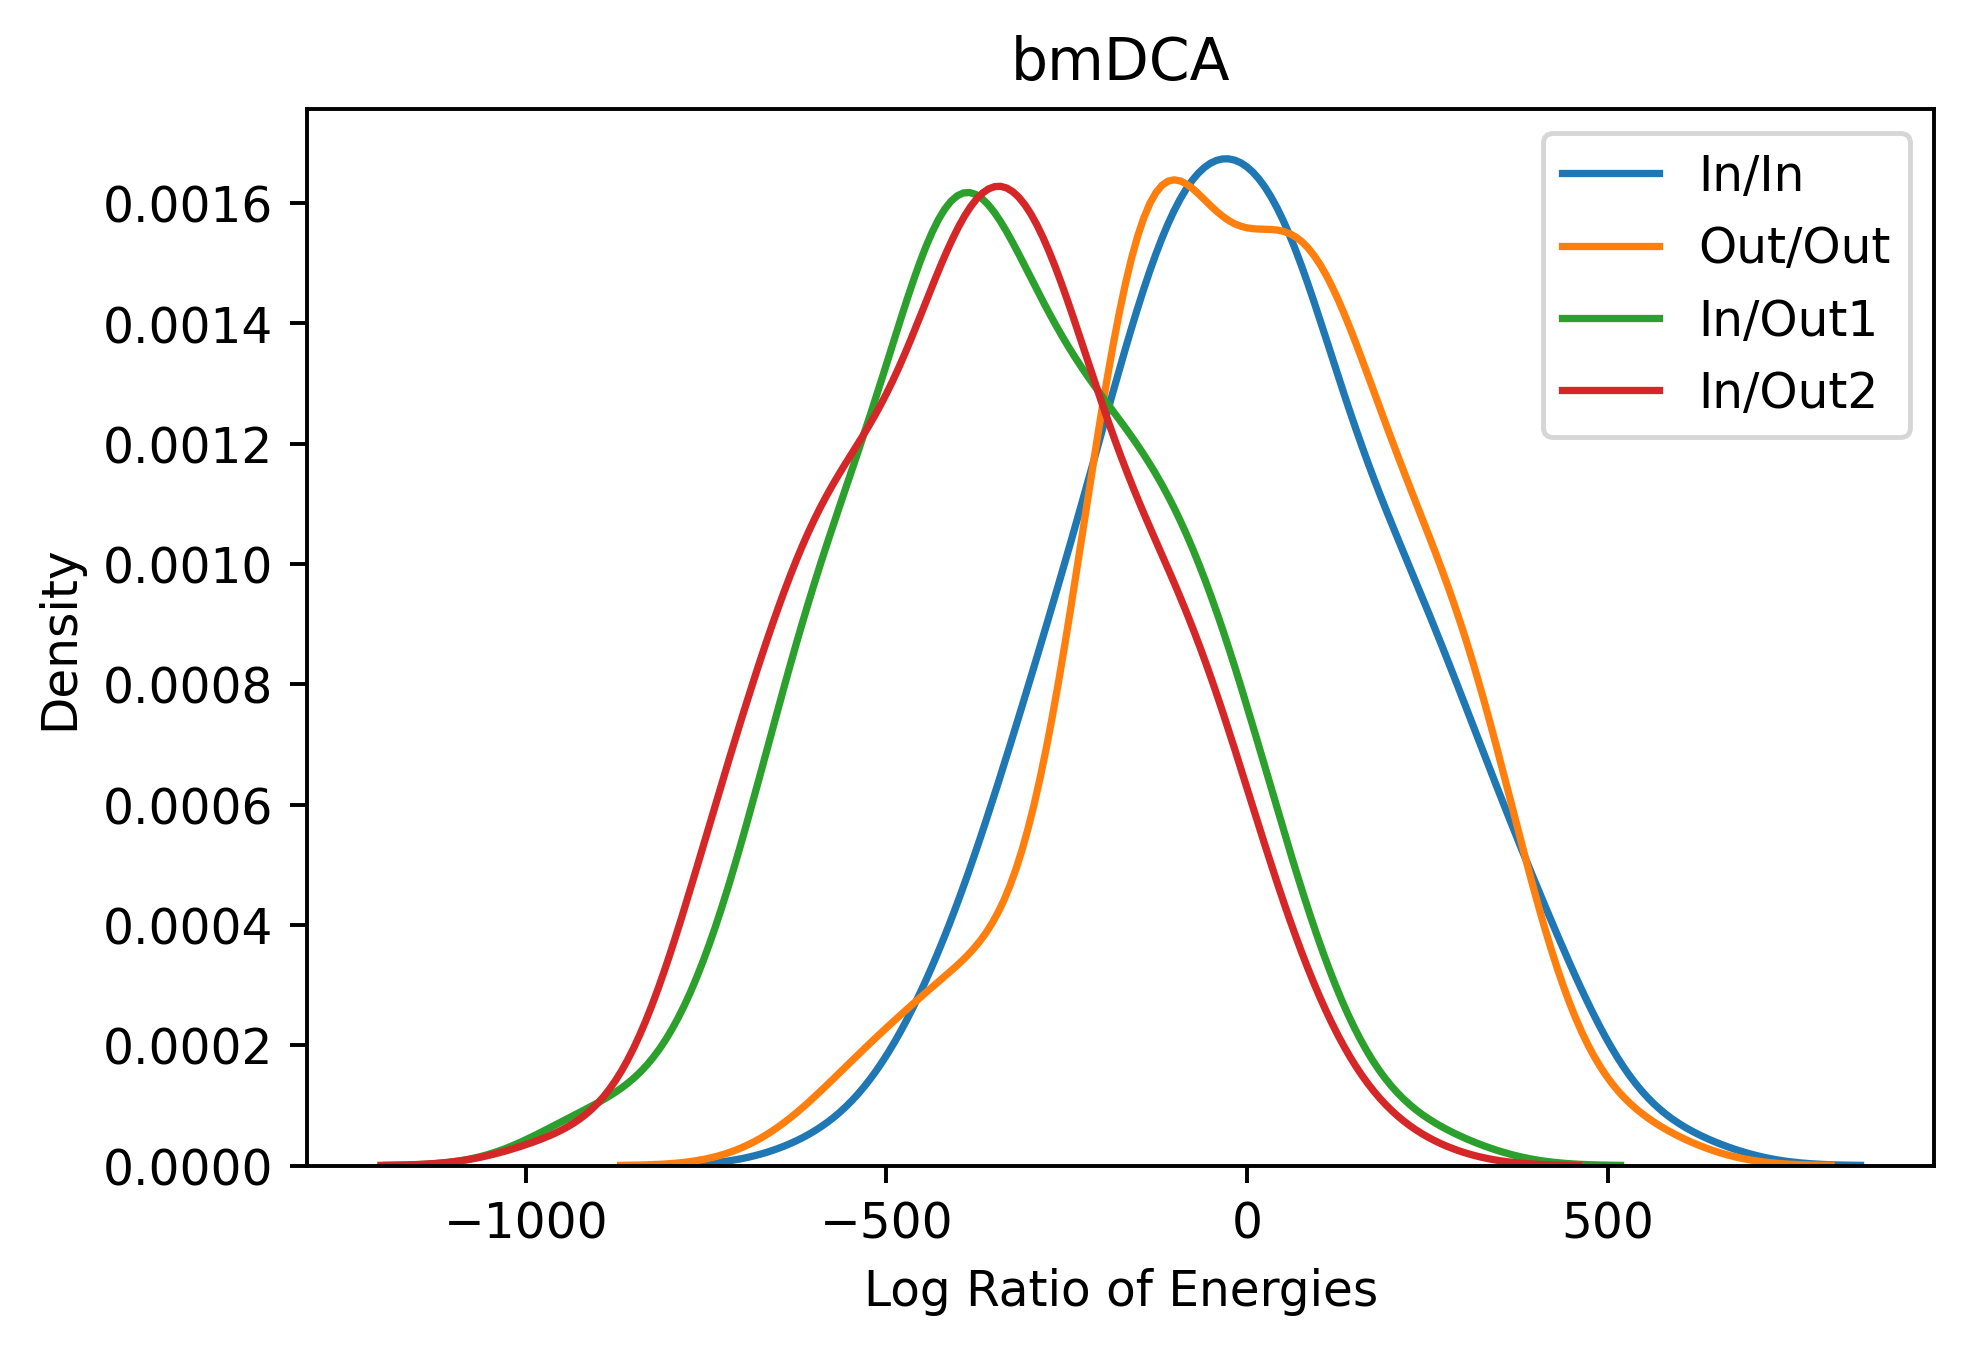

In [ ]:
import seaborn as sns

sns.kdeplot(in_ratios, label = "In/In")
sns.kdeplot(out_ratios, label = "Out/Out")
sns.kdeplot(in_out1_ratios, label = "In/Out1")
sns.kdeplot(in_out2_ratios, label = "In/Out2")

plt.legend()
plt.title('bmDCA')
plt.xlabel('Log Ratio of Energies')
plt.ylabel('Density')

In [ ]:
get_fp(in_ratios, in_out2_ratios)

False positive score:  0.46134465032082


#### First & second order correlations

In [ ]:
from scipy import stats

def first_order(X_data, X_samp, show=True):
    """
    Show scatterplot of the sitewise frequencies of data vs. samples

    Inputs are numpy arrays of shape (batch_size, seq_len, 21)
    """
    b_data, l_data, d_data = X_data.shape
    b_samp, l_samp, d_samp = X_samp.shape
    assert l_data == l_samp
    assert d_data == d_samp

    # sum along the batch dimension
    freqs_data = np.sum(X_data, axis=0).flatten() / b_data
    freqs_samp = np.sum(X_samp, axis=0).flatten() / b_samp

    if show:
        print("Spearman: ", stats.pearsonr(freqs_data, freqs_samp)[0])
        plt.scatter(freqs_data, freqs_samp, s=1, c='red')
        plt.title("First Order Correlations")
        plt.xlabel("Frequencies in data")
        plt.ylabel("Frequences in samples")
        plt.show()
    else:
        return freqs_data, freqs_samp


In [ ]:
aa1, aa2 = np.meshgrid(np.arange(21), np.arange(21))
aa1 = aa1.flatten()
aa2 = aa2.flatten()

def second_order(X_data, X_samp):
    """
    Show scatterplot of the pairwise frequencies of data vs. samples

    Inputs are numpy arrays of shape (batch_size, seq_len, 21)
    """
    data_sites, samp_sites = first_order(X_data, X_samp, show=False)
    X_data = torch.from_numpy(X_data).to(device)
    X_samp = torch.from_numpy(X_samp).to(device)
    data_sites = torch.from_numpy(data_sites).to(device)
    samp_sites = torch.from_numpy(samp_sites).to(device)
    b_data, l, d = X_data.shape
    b_samp, l, d = X_samp.shape

    freqs_data = []
    freqs_samp = []
    aas = []
    
    for i in tq.tqdm(range(l)):
        for j in range(i+1, l):
            data_pairs = torch.sum(torch.logical_and(X_data[:,i,aa1] == 1, X_data[:,j,aa2] == 1), dim=0)/b_data
            samp_pairs = torch.sum(torch.logical_and(X_samp[:,i,aa1] == 1, X_samp[:,j,aa2] == 1), dim=0)/b_samp
            fd = data_pairs - data_sites[i*q + aa1]*data_sites[j*q + aa2]
            fs = samp_pairs - samp_sites[i*q + aa1]*samp_sites[j*q + aa2]
            idx = torch.logical_and(fd > 0, fs > 0)
            freqs_data.append(list(fd[idx].cpu()))
            freqs_samp.append(list(fs[idx].cpu()))
    
    return freqs_data, freqs_samp


In [ ]:
freqs_data, freqs_samp = second_order(X_data, X_sample)

In [ ]:
import itertools

freqs_data_flat = list(itertools.chain.from_iterable(freqs_data))
freqs_samp_flat = list(itertools.chain.from_iterable(freqs_samp))

Spearman:  0.48853071982670737


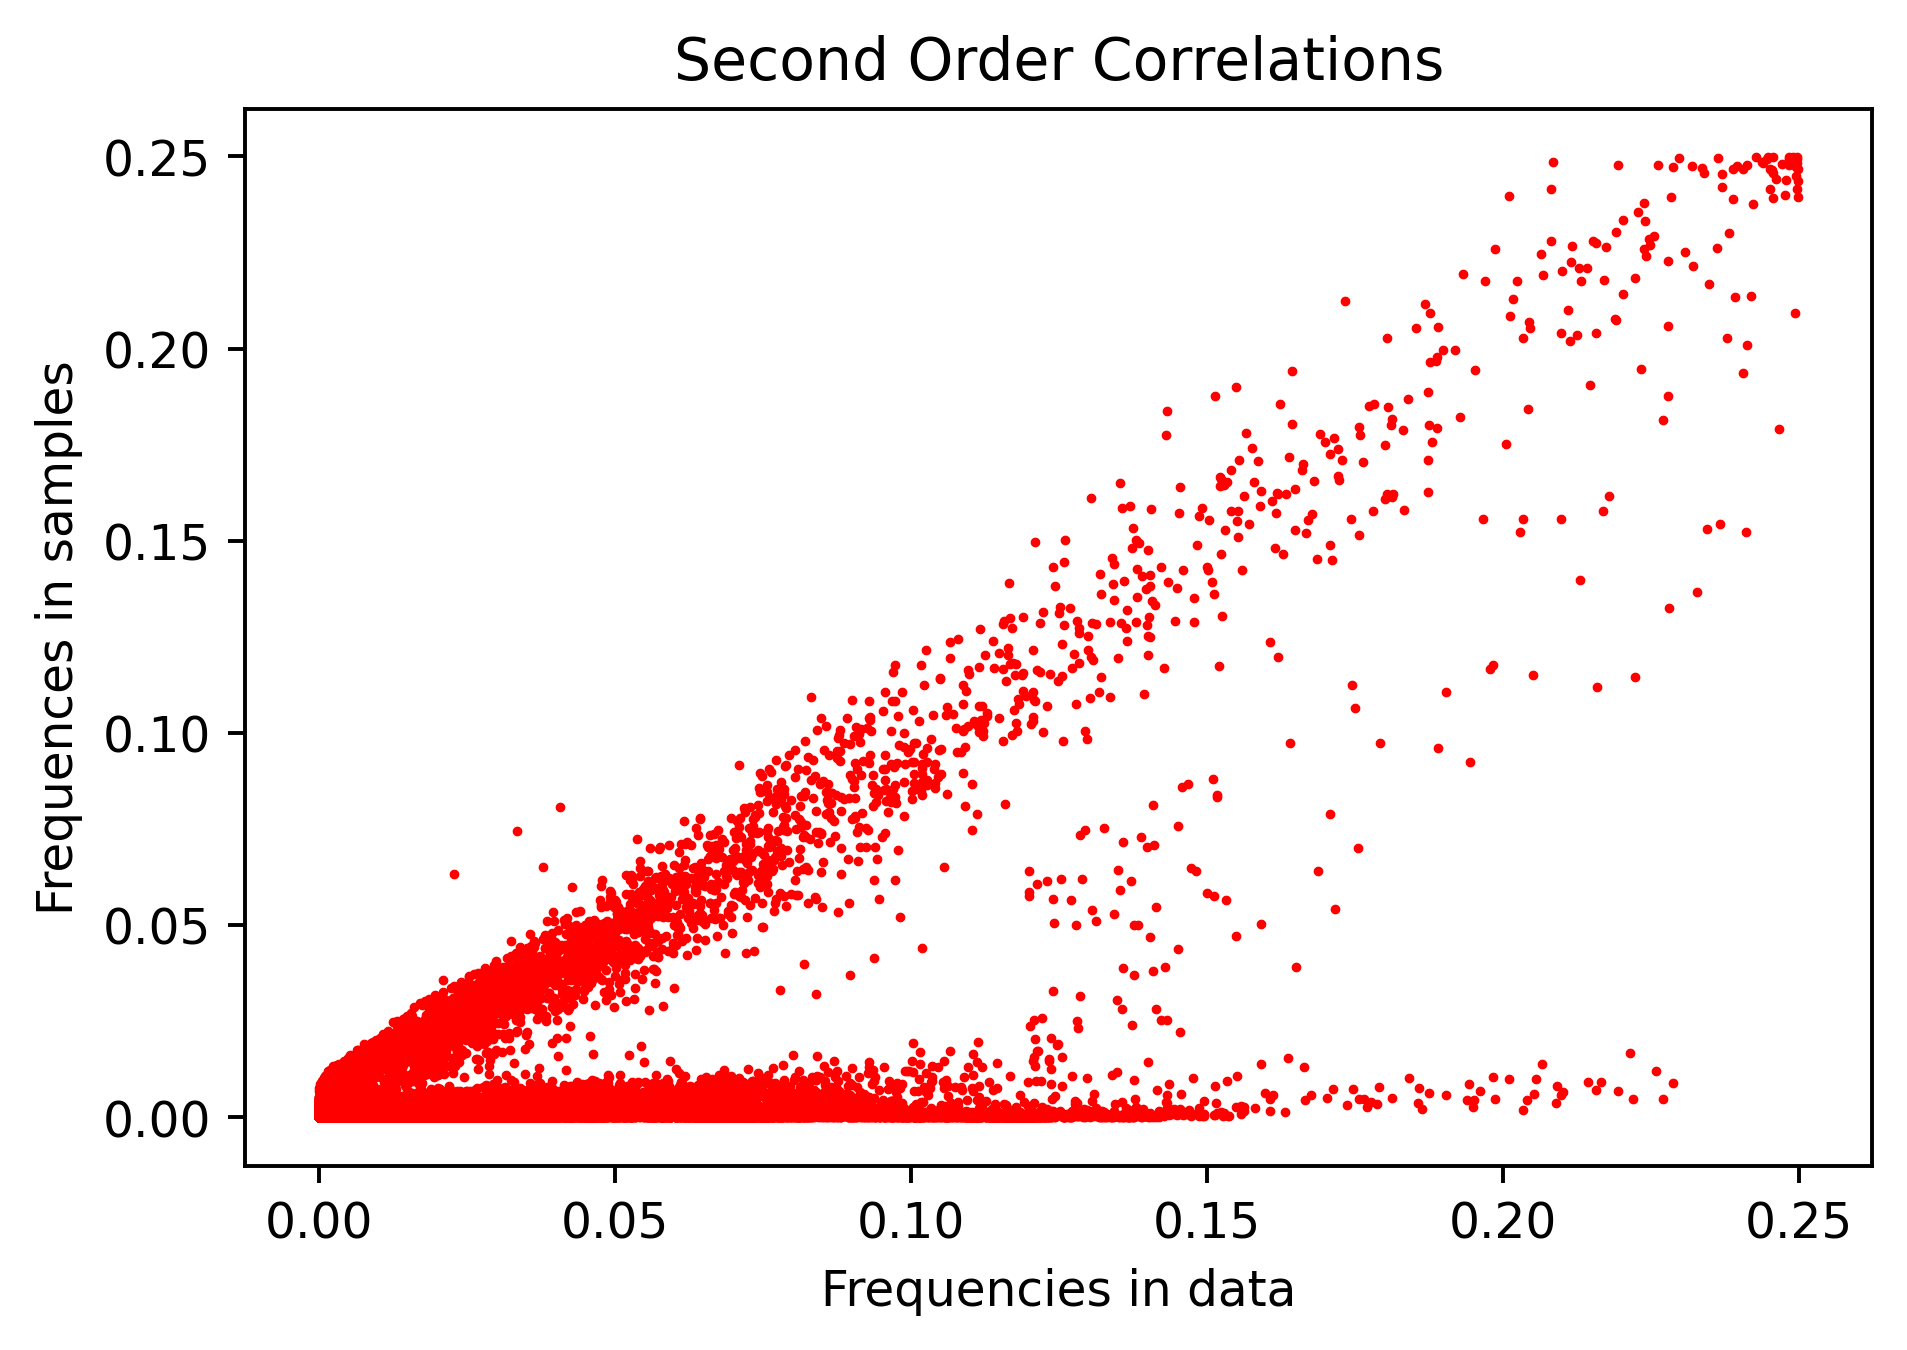

In [ ]:
print("Spearman: ", stats.pearsonr(freqs_data_flat, freqs_samp_flat)[0])
plt.scatter(freqs_data_flat, freqs_samp_flat, s=1, c='red')
plt.title("Second Order Correlations")
plt.xlabel("Frequencies in data")
plt.ylabel("Frequences in samples")
plt.show()

In [ ]:
X_data =  read_fasta("/content/lcc_short.fasta")

In [ ]:
X_sample =  read_fasta("/content/samples.txt")

Spearman:  0.9642222924882256


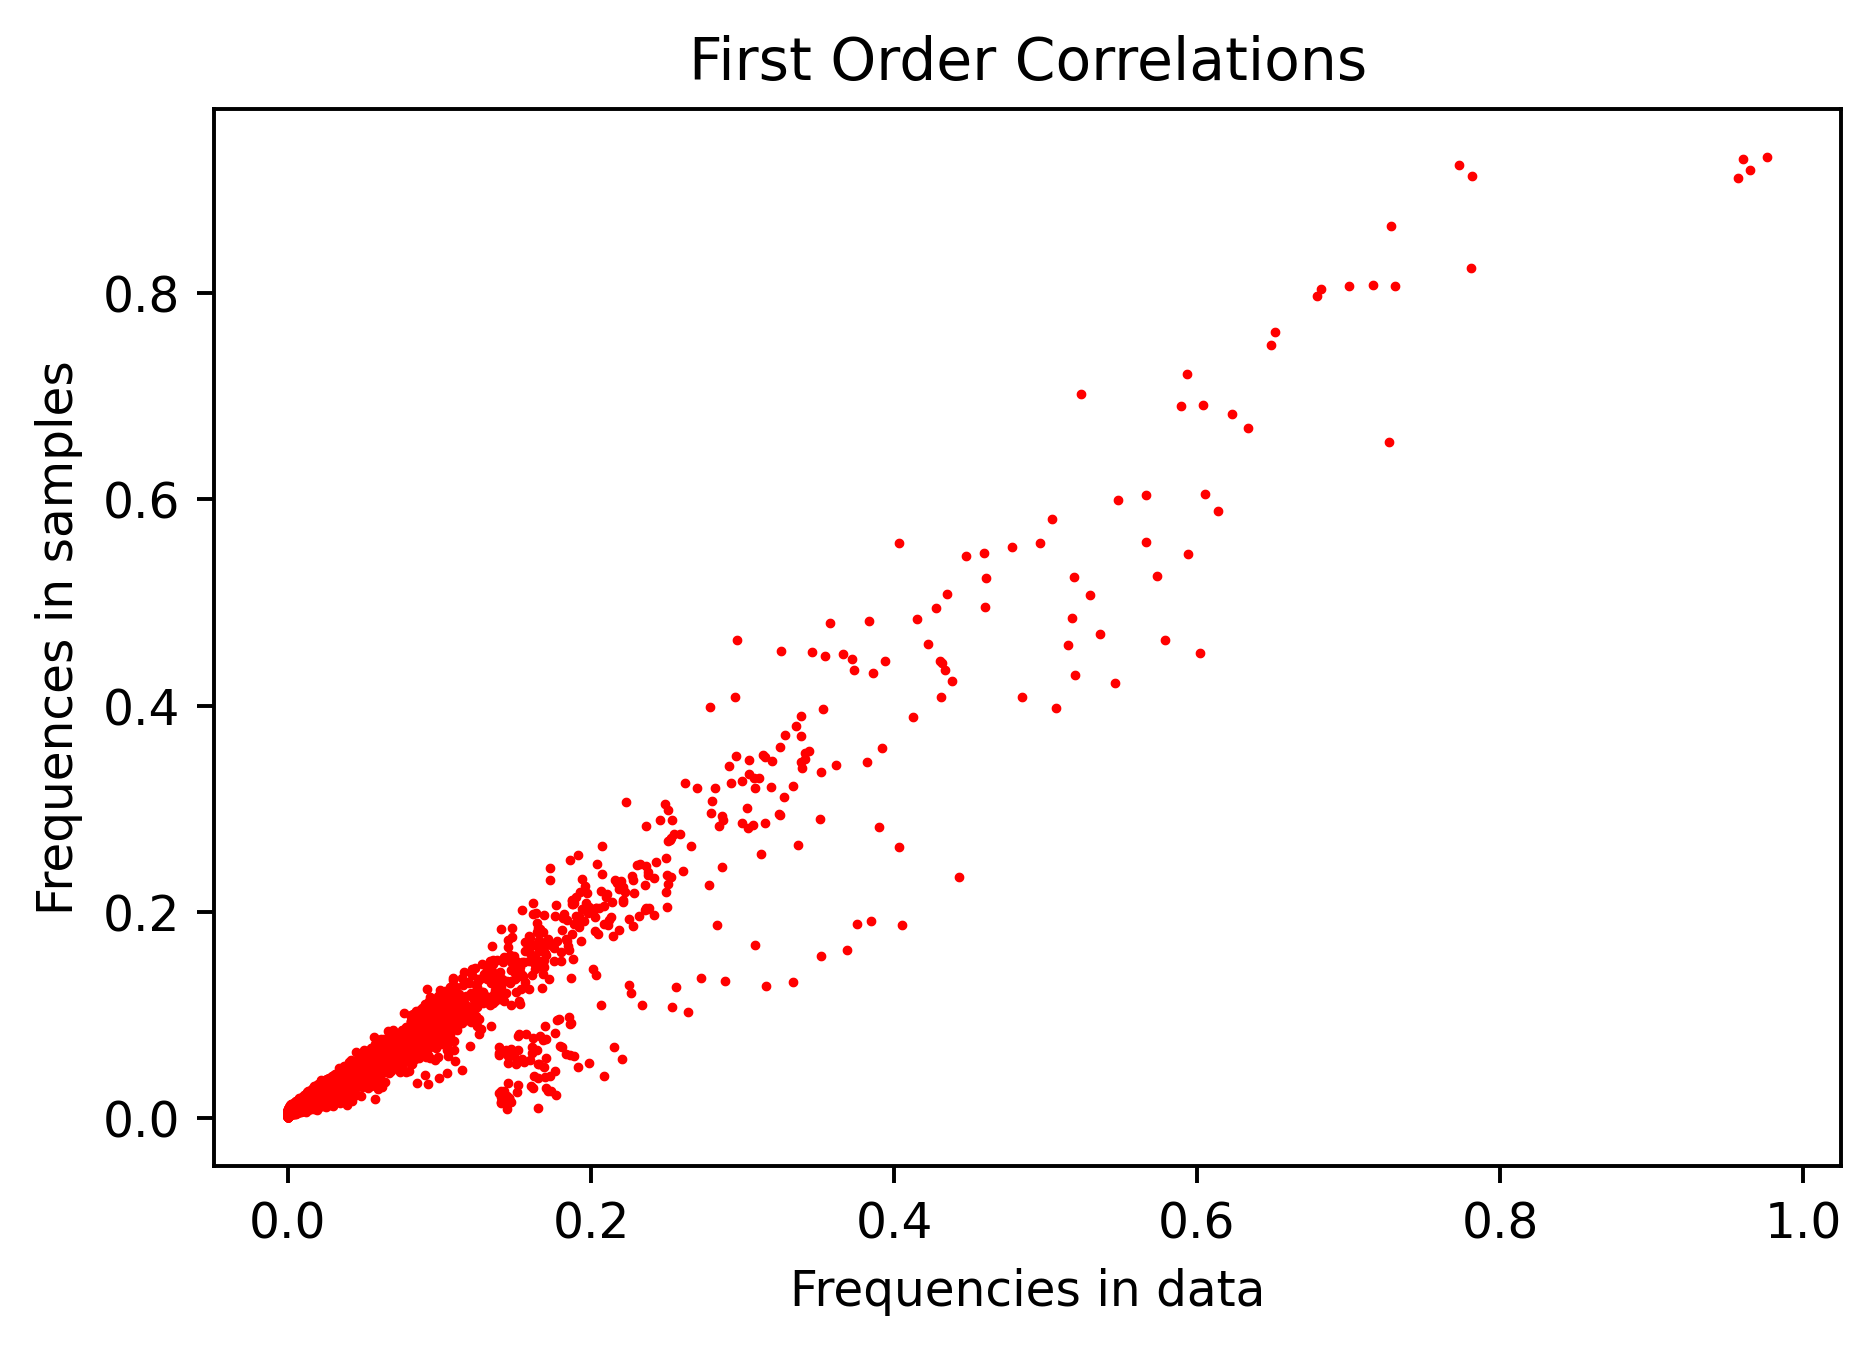

In [ ]:
first_order(X_data, X_sample)

#### Sequence Identity

In [ ]:
def seq_identity(X_data, X_samp):
    """
    Plots a distribution of the percent sequence identity of each sampled
    sequence with closest sequence in the data
    """
    _, l, d = X_data.shape
    X_data = X_data.reshape(-1,l*d)
    X_samp = X_samp.reshape(-1,l*d)
    identities = []
    X_data = torch.from_numpy(X_data).to(device)
    X_samp = torch.from_numpy(X_samp).to(device)
    for s in tq.tqdm(X_samp):
        # this is valid because the sequences are aligned
        identity = torch.max(l - torch.sum(torch.abs(X_data - s), dim=1)/2)/l
        identities.append(identity.item())

    return identities

idents_bmdca = seq_identity(X_data, X_sample)
# plt.hist(idents, alpha=0.3)
# plt.xlabel("Sequence Identity")
# plt.ylabel("Frequency")
# plt.title("Sequence Identities of Samples")
# plt.show()

Contacts

In [ ]:
w = J.numpy().reshape(227, 21, 227, 21)
L2, L5 = get_contacts(w, showContacts=False)

In [ ]:
get_precision(L2, L5)

0.336283185840708
0.18584070796460178


### Contrastive Divergence

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
import random

In [ ]:
L = 227
q = 21

class Potts(torch.nn.Module):
    def __init__(self):
        super(Potts, self).__init__()

        self.J = torch.nn.Parameter(torch.zeros(L*q, L*q), requires_grad=True) 
        self.h = torch.nn.Parameter(torch.zeros(L*q), requires_grad=True)

    def forward(self, X):
        # X = X.reshape(-1, L*A)
        J = ((self.J + self.J.T) / 2.0).to(device)   # make symmetric
        H = torch.tensor(0.0).to(device)
        for s in X:
            H += logE(s, self.h, J)
        return H

def loss_fn(model, Xin, Xout, L2=None):
    """
    Objective: negative (logp_in - logp_out)
    """
    J = ((model.J + model.J.T) / 2.0).to(device)
    ratio = model(Xin) - model(Xout)
    if L2 is not None:
        ratio += L2 * (torch.sum(J**2) + torch.sum(model.h**2))
    return ratio

def loss_fn_weighted(model, Xin, Xout, w, L2=None):
    """
    Same as loss_fn() but with sequence weights stored in w
    """
    J = ((model.J + model.J.T) / 2.0).to(device)

    def forward_(X, w=None):
        if w is None:
            w = torch.ones(X.shape[0]).to(device)
        H = torch.tensor(0.0).to(device)
        for i, s in enumerate(X):
            H += w[i]*logE(s, model.h, J)
        return H
    
    ratio = forward_(Xin, w=w) - forward_(Xout)
    if L2 is not None:
        ratio += L2 * (torch.sum(J**2) + torch.sum(model.h**2))
    return ratio
    

def sample_from(model, num_samples=10, Tstart=2.0, Tend=1.0, Tsteps=10, seqlen=227, showProg=False):
    """
    sample from the potts model with MCMC with annealing
    """
    # maybe start from some seed sequence instead of random?
    X = torch.randint(21, (num_samples, seqlen)).to(device)

    temps = torch.flip(torch.linspace(Tstart, Tend, Tsteps), (0, ))
    with torch.no_grad():
        for t in temps:
            E = torch.zeros(num_samples)
            E_mut = torch.zeros(num_samples)
            if showProg:
                for i, s in tq.tqdm(enumerate(X)):
                    J = (model.J + model.J.T) / 2.0
                    E[i] = logE(s, model.h, J).item()
            else:
                for i, s in enumerate(X):
                    J = (model.J + model.J.T) / 2.0
                    E[i] = logE(s, model.h, J).item()
            X = X.view(num_samples*seqlen,)
            X_mut = torch.zeros_like(X)
            mut_pos = torch.from_numpy(np.random.choice(num_samples*seqlen, size=2*num_samples, replace=False))
            mut_res = torch.randint(1, 21, (len(mut_pos), )).to(device)
            X_mut[mut_pos] = (X[mut_pos] + mut_res) % 21
            X_mut = X_mut.view(num_samples, seqlen)
            X = X.view(num_samples, seqlen)
            if showProg:
                for i, s in tq.tqdm(enumerate(X)):
                    J = (model.J + model.J.T) / 2.0
                    E_mut[i] = logE(s, model.h, J).item()
            else:
                for i, s in enumerate(X):
                    J = (model.J + model.J.T) / 2.0
                    E_mut[i] = logE(s, model.h, J).item()

            deltaE = E_mut - E
            X_res = torch.zeros_like(X)
            accept = torch.logical_or(torch.rand(num_samples) > torch.exp(-deltaE/t), 
                                      deltaE < 0)
            reject = torch.logical_not(accept)
            X_res[accept] = X_mut[accept]
            X_res[reject] = X[reject]
    return X
            

For an unbiased comparison of contrastive divergence samples with bmDCA samples, try using bmDCA sampler with `potts_model.h` and `potts_model.J` as inputs to `bmdca_sample`

Also a speed boost: current `sample_from()` does 100seqs/min, but `bmdca_sample` is about 10x faster

In [ ]:
def save_params(model):
    """
    Saves model parameters h and J as a .txt file with the same format
    as parameters.txt in bmDCA
    """
    h = model.h.detach().cpu().numpy()
    J = ((model.J + model.J.T) / 2.0).detach().cpu().numpy()
    h_txt = ""
    J_txt = ""
    for i in range(L):
        for aa in range(21):
            h_txt += "h {} {} {}\n".format(i, aa, h[i*q + aa])
    for i in tq.tqdm(range(L)):
        for j in range(i+1, L):
            for aa1 in range(21):
                for aa2 in range(21):
                    J_txt += "J {} {} {} {} {}\n".format(i, j, aa1, aa2, 
                                                                 J[i*q + aa1, j*q + aa2])
    with open("parameters.txt", 'w') as f:
        f.write(J_txt)
        f.write(h_txt)

In [ ]:
def train_potts(X_data, batch_size=64, epochs=200, lr=1e-4, L2=0.1):
    """
    X_data: Dataset object wrapping a list of sequences encoded as integers
    """
    
    train, test = train_test_split(list(range(len(X_data))), test_size=.2)

    train_loader = DataLoader(X_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(train))
    test_loader = DataLoader(X_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(test))

    potts_model = Potts().to(device)

    optimizer = torch.optim.Adam(potts_model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-3, cycle_momentum=False)
    train_loss, test_loss = [], []

    for epoch in range(epochs):
        total_train_loss, total_test_loss = 0, 0        

        for Xin in tq.tqdm(train_loader):
            potts_model.train()
            optimizer.zero_grad()

            Xout = sample_from(potts_model, num_samples=batch_size)
            # print("computing loss")
            loss = loss_fn(potts_model, Xin, Xout, L2=L2)
            total_train_loss += loss.item()
            # print(loss.item())

            loss.backward()
            optimizer.step()

        train_loss.append(total_train_loss / len(train_loader))

        for Xin in test_loader:
            potts_model.eval()

            Xout = sample_from(potts_model, num_samples=batch_size)
            loss = loss_fn(potts_model, Xin, Xout, L2=L2)
            total_test_loss += loss.item()
            break
            
        test_loss.append(total_test_loss)
    torch.save(potts_model.state_dict(), "model.pt")
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.show()

    

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class SequenceData(Dataset):

    def __init__(self, X):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).to(device)
        else:
            self.X = X.to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]


In [ ]:
in_dist = torch.from_numpy(in_dist).to(device)

In [ ]:
X_data = SequenceData(in_dist)

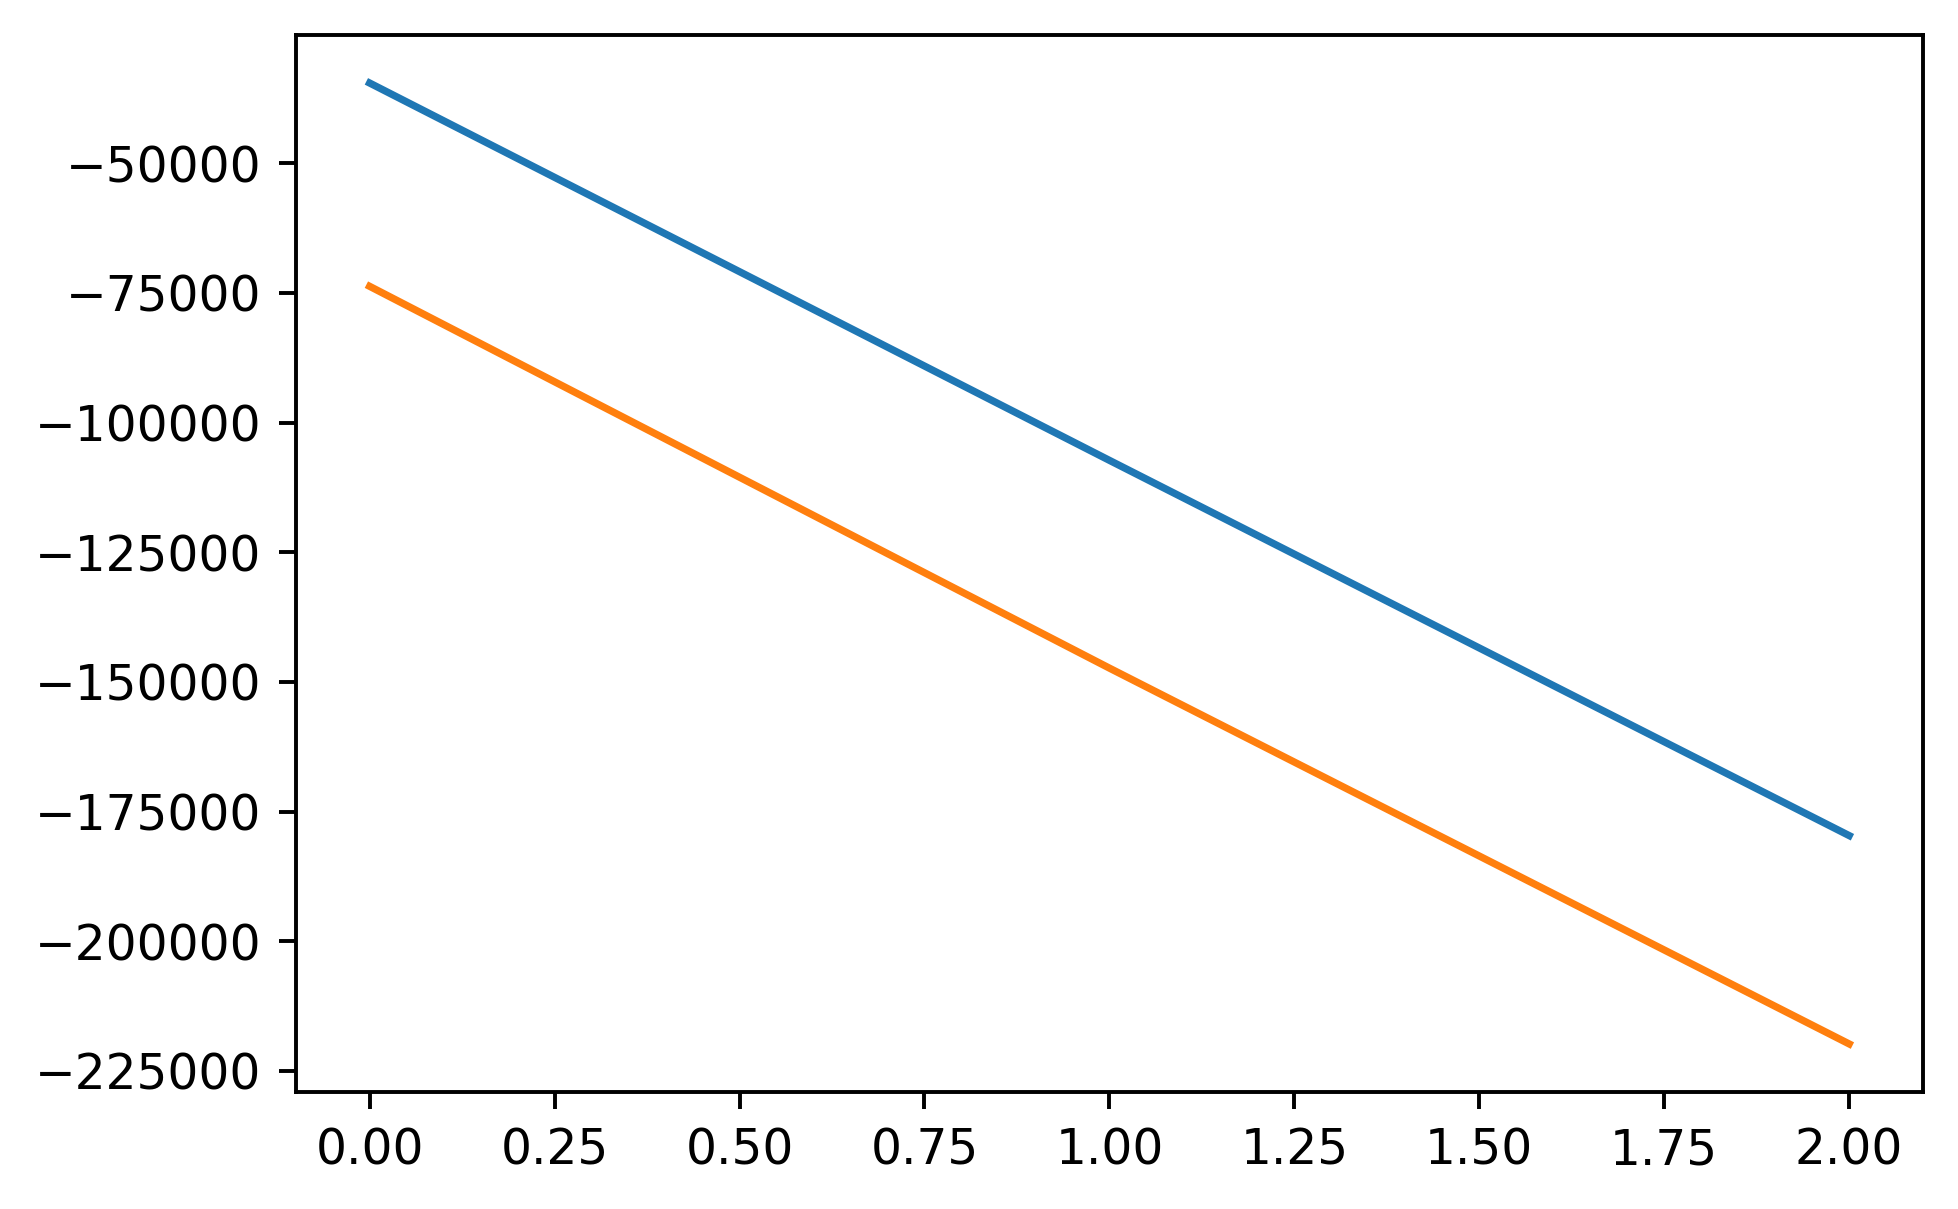

In [ ]:
train_potts(X_data, batch_size=512, epochs=3, lr=1e-4, L2=0.02)

### Model evaluation

In [ ]:
potts_model = Potts()
potts_model.load_state_dict(torch.load("model.pt"))
potts_model.eval()

Potts()

Text(0, 0.5, 'Density')

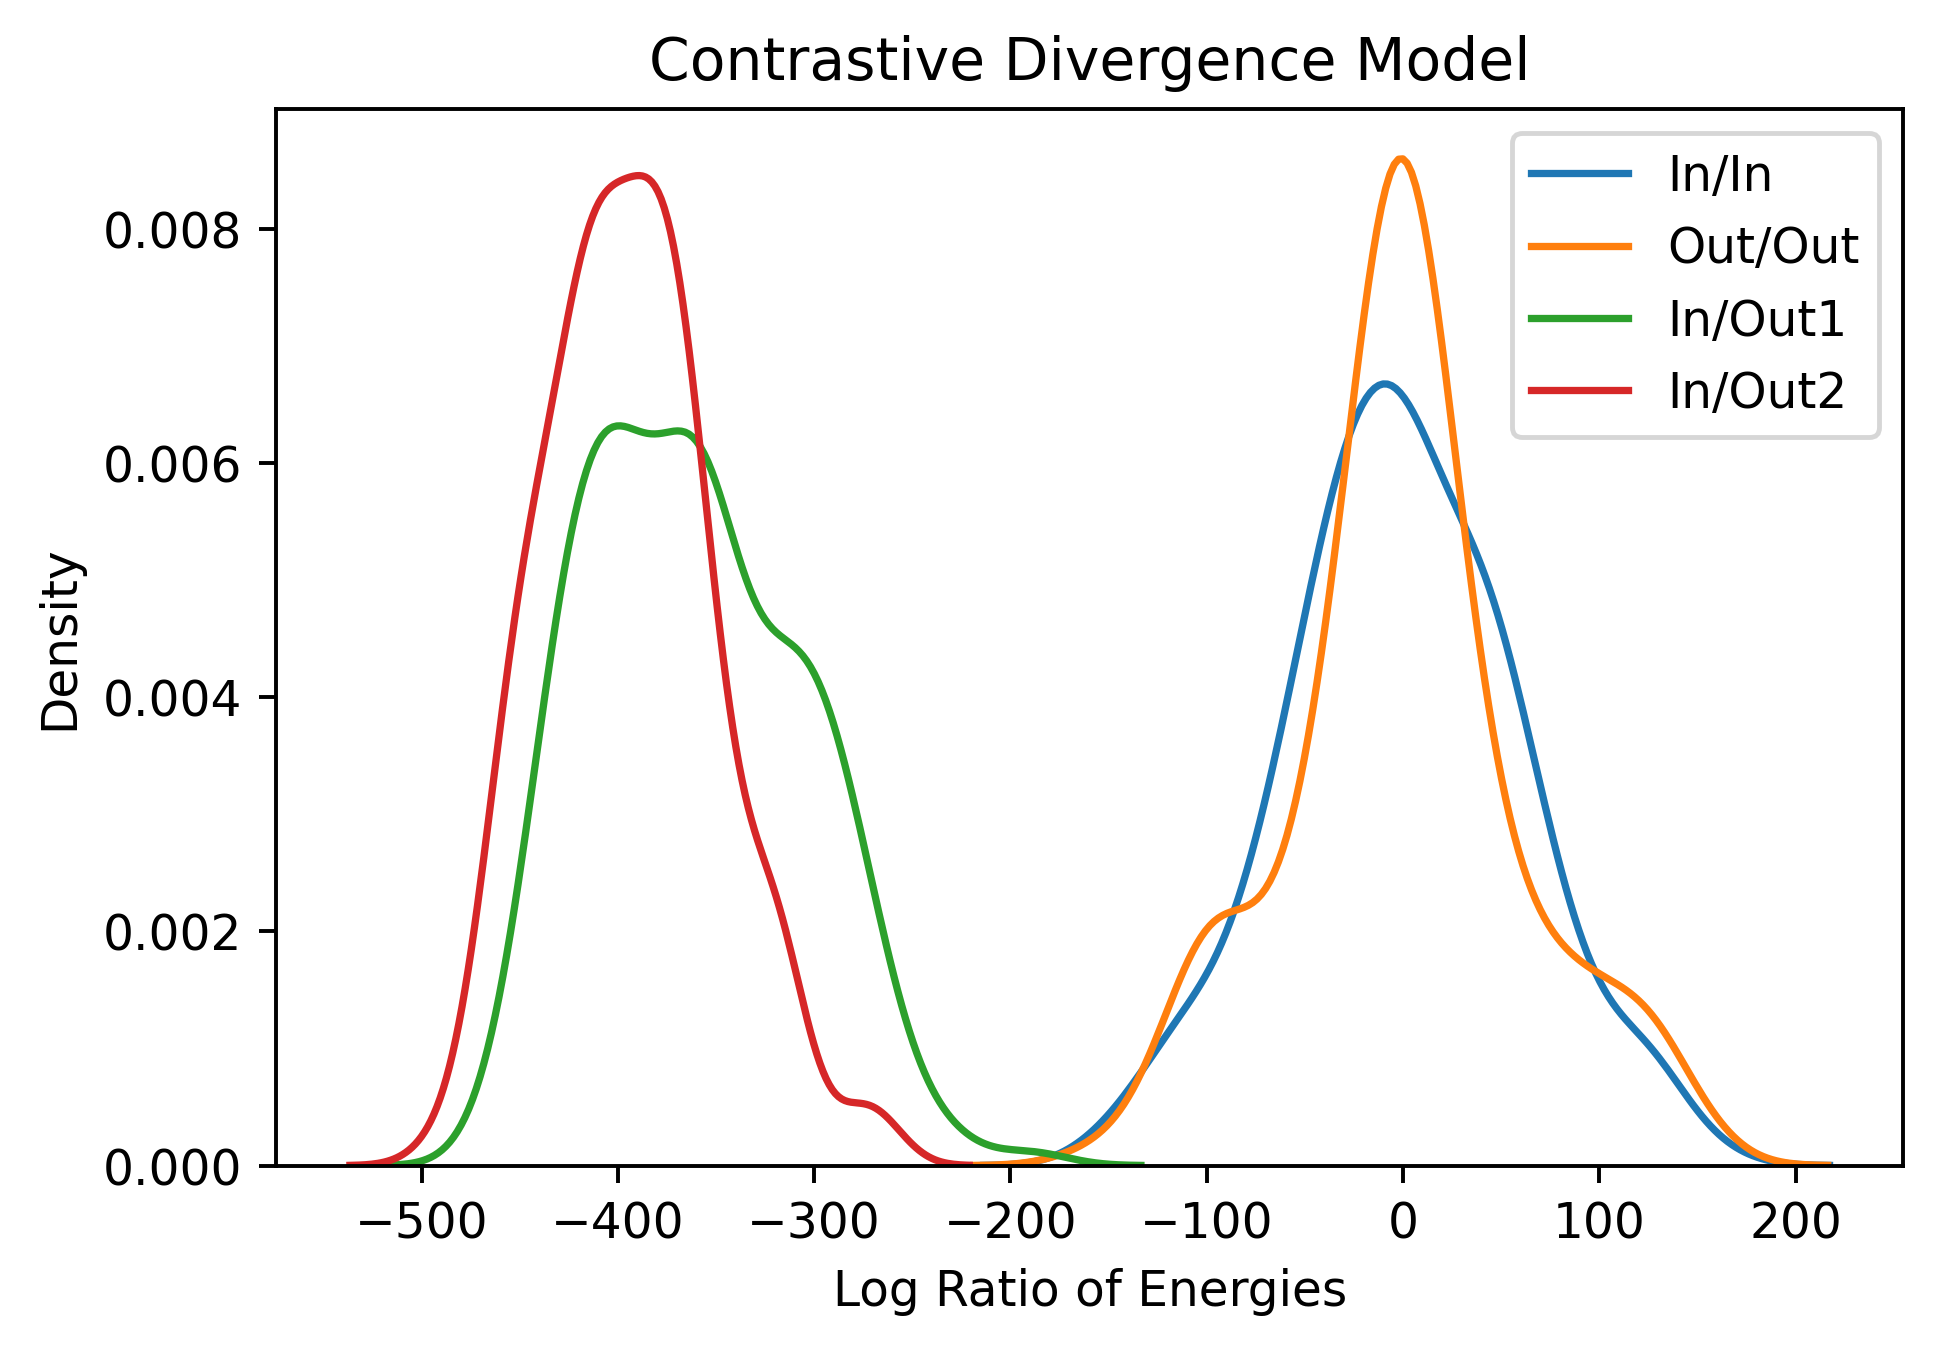

In [ ]:
import numpy as np

in_dist = get_numerical_aas("lcc_short.fasta")
out_dist1 = torch.from_numpy(np.array([np.random.permutation(s) for s in in_dist])).to(device)
out_dist2 = torch.from_numpy(np.array([np.concatenate((s[int(L/2):], s[:int(L/2)])) for s in in_dist])).to(device)
in_dist = torch.from_numpy(in_dist).to(device)

in_ratios = []
out_ratios = []
in_out1_ratios = []
in_out2_ratios = []
h = potts_model.h
J = (potts_model.J + potts_model.J.T) / 2.0
for i in tq.tqdm(range(200)):
    in_out1_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist1[i], h, J).item())
    in_out2_ratios.append(logE(in_dist[i], h, J).item() - logE(out_dist2[i], h, J).item())
    in_ratios.append(logE(in_dist[i], h, J).item() - logE(in_dist[i+1], h, J).item())
    out_ratios.append(logE(out_dist1[i], h, J).item() - logE(out_dist1[i+1], h, J).item())

import seaborn as sns

sns.kdeplot(in_ratios, label = "In/In")
sns.kdeplot(out_ratios, label = "Out/Out")
sns.kdeplot(in_out1_ratios, label = "In/Out1")
sns.kdeplot(in_out2_ratios, label = "In/Out2")

plt.legend()
plt.title('Contrastive Divergence Model')
plt.xlabel('Log Ratio of Energies')
plt.ylabel('Density')

In [ ]:
get_fp(in_ratios, in_out2_ratios)

False positive score:  1.2138920234999564e-06


Contacts

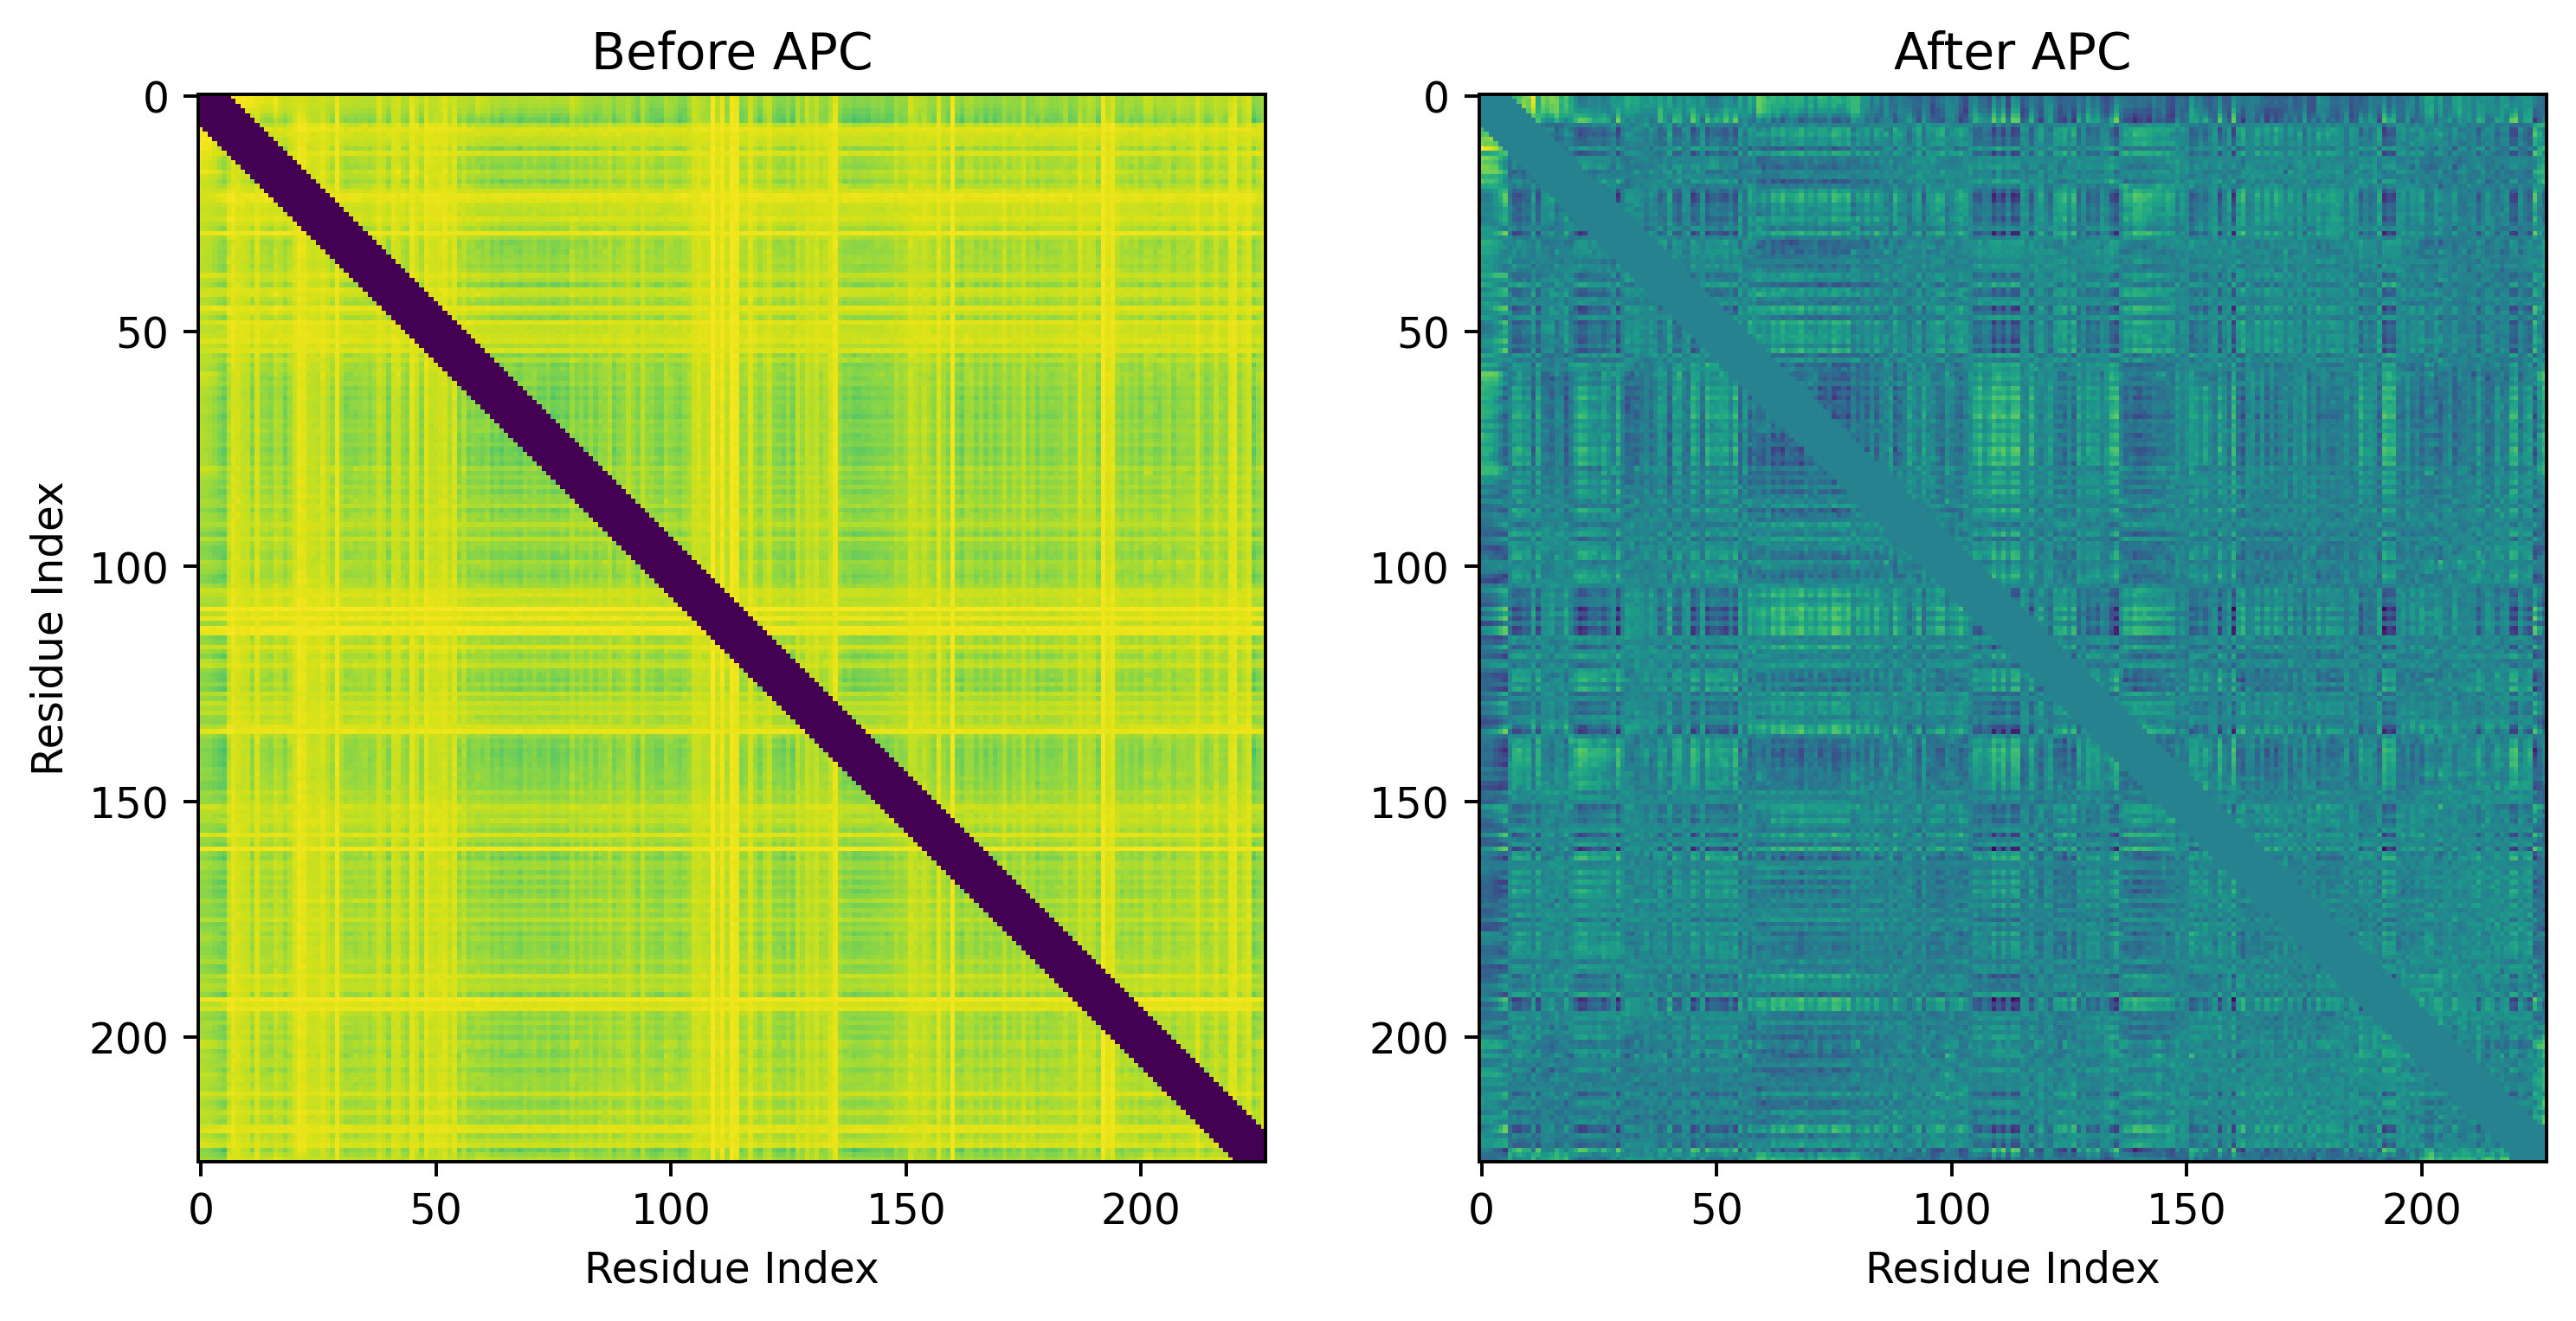

0.05309734513274336
0.017699115044247787


In [ ]:
w = J.cpu().detach().numpy().reshape(227, 21, 227, 21)
L2, L5 = get_contacts(w, showContacts=True)
get_precision(L2, L5)

#### Sampling

In [ ]:
save_params(potts_model)

In [ ]:
%%shell
bmdca_sample -p /content/parameters.txt \
             -d /content -o samples.txt -n 1000 -r 10

initializing sampler... 4.20317 sec

sampling model with mcmc... 48.1872 sec
updating mcmc stats with samples... 4.07372 sec
computing sequence energies and correlations... 0.307317 sec
writing final sequences... done


#### First & second order correlations

In [ ]:
samples = read_fasta("samples.txt").numpy()
xin = read_fasta("lcc_short.fasta").numpy()

Spearman:  0.9514781814652258


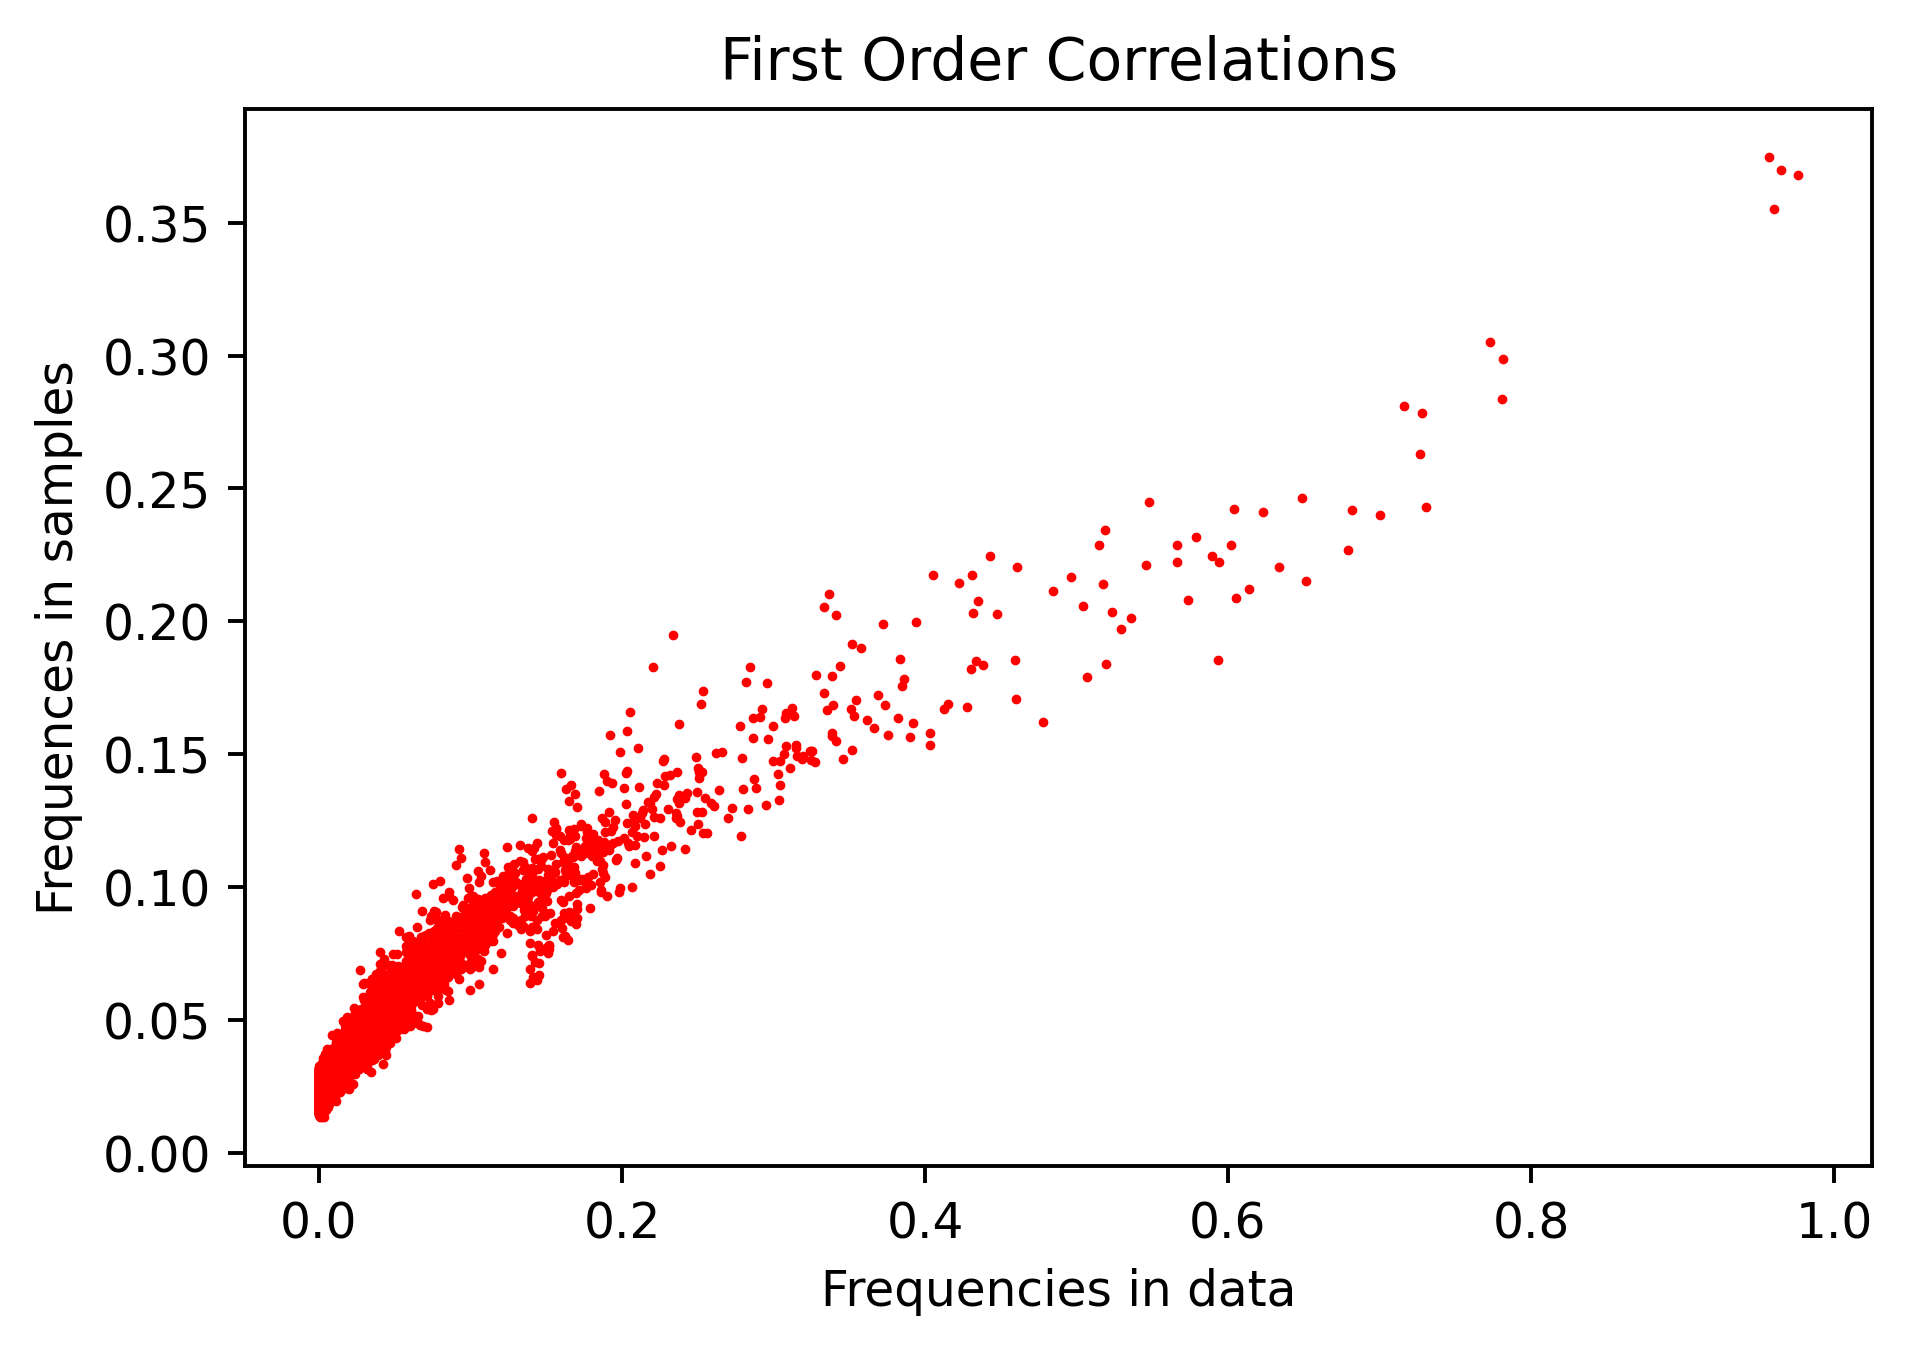

In [ ]:
first_order(xin, samples)

In [ ]:
freqs_data, freqs_samp = second_order(xin, samples)

Spearman:  0.22266006307375172


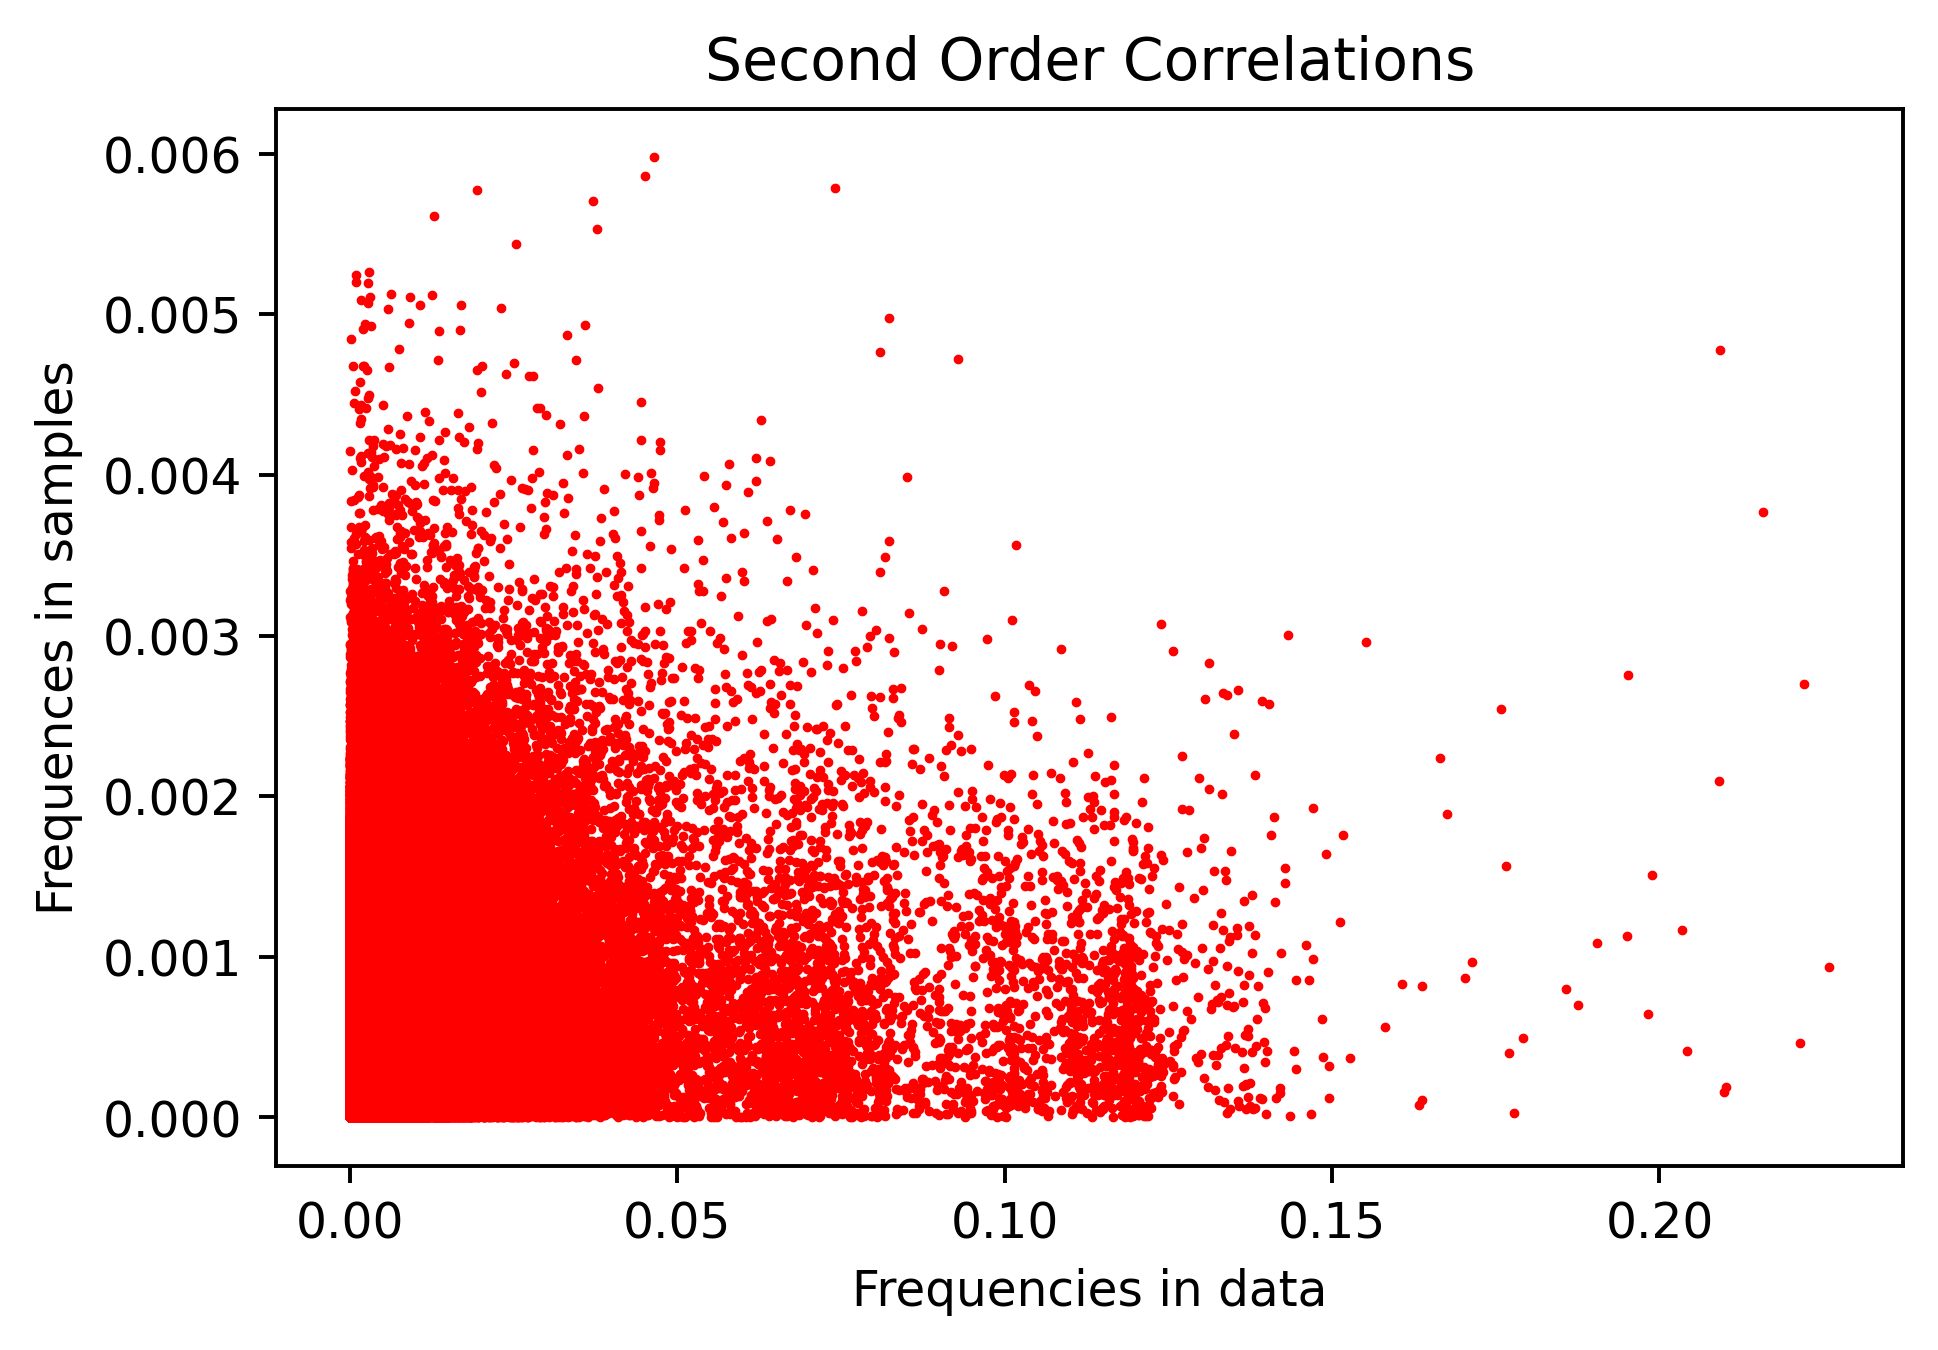

In [ ]:
import itertools

freqs_data_flat = list(itertools.chain.from_iterable(freqs_data))
freqs_samp_flat = list(itertools.chain.from_iterable(freqs_samp))

print("Spearman: ", stats.pearsonr(freqs_data_flat, freqs_samp_flat)[0])
plt.scatter(freqs_data_flat, freqs_samp_flat, s=1, c='red')
plt.title("Second Order Correlations")
plt.xlabel("Frequencies in data")
plt.ylabel("Frequences in samples")
plt.show()

#### Sequence identity

In [ ]:
idents_contra = seq_identity(xin, samples)
# plt.hist(idents, alpha=0.3)
# plt.xlabel("Sequence Identity")
# plt.ylabel("Frequency")
# plt.title("Sequence Identities of Samples")
# plt.show()

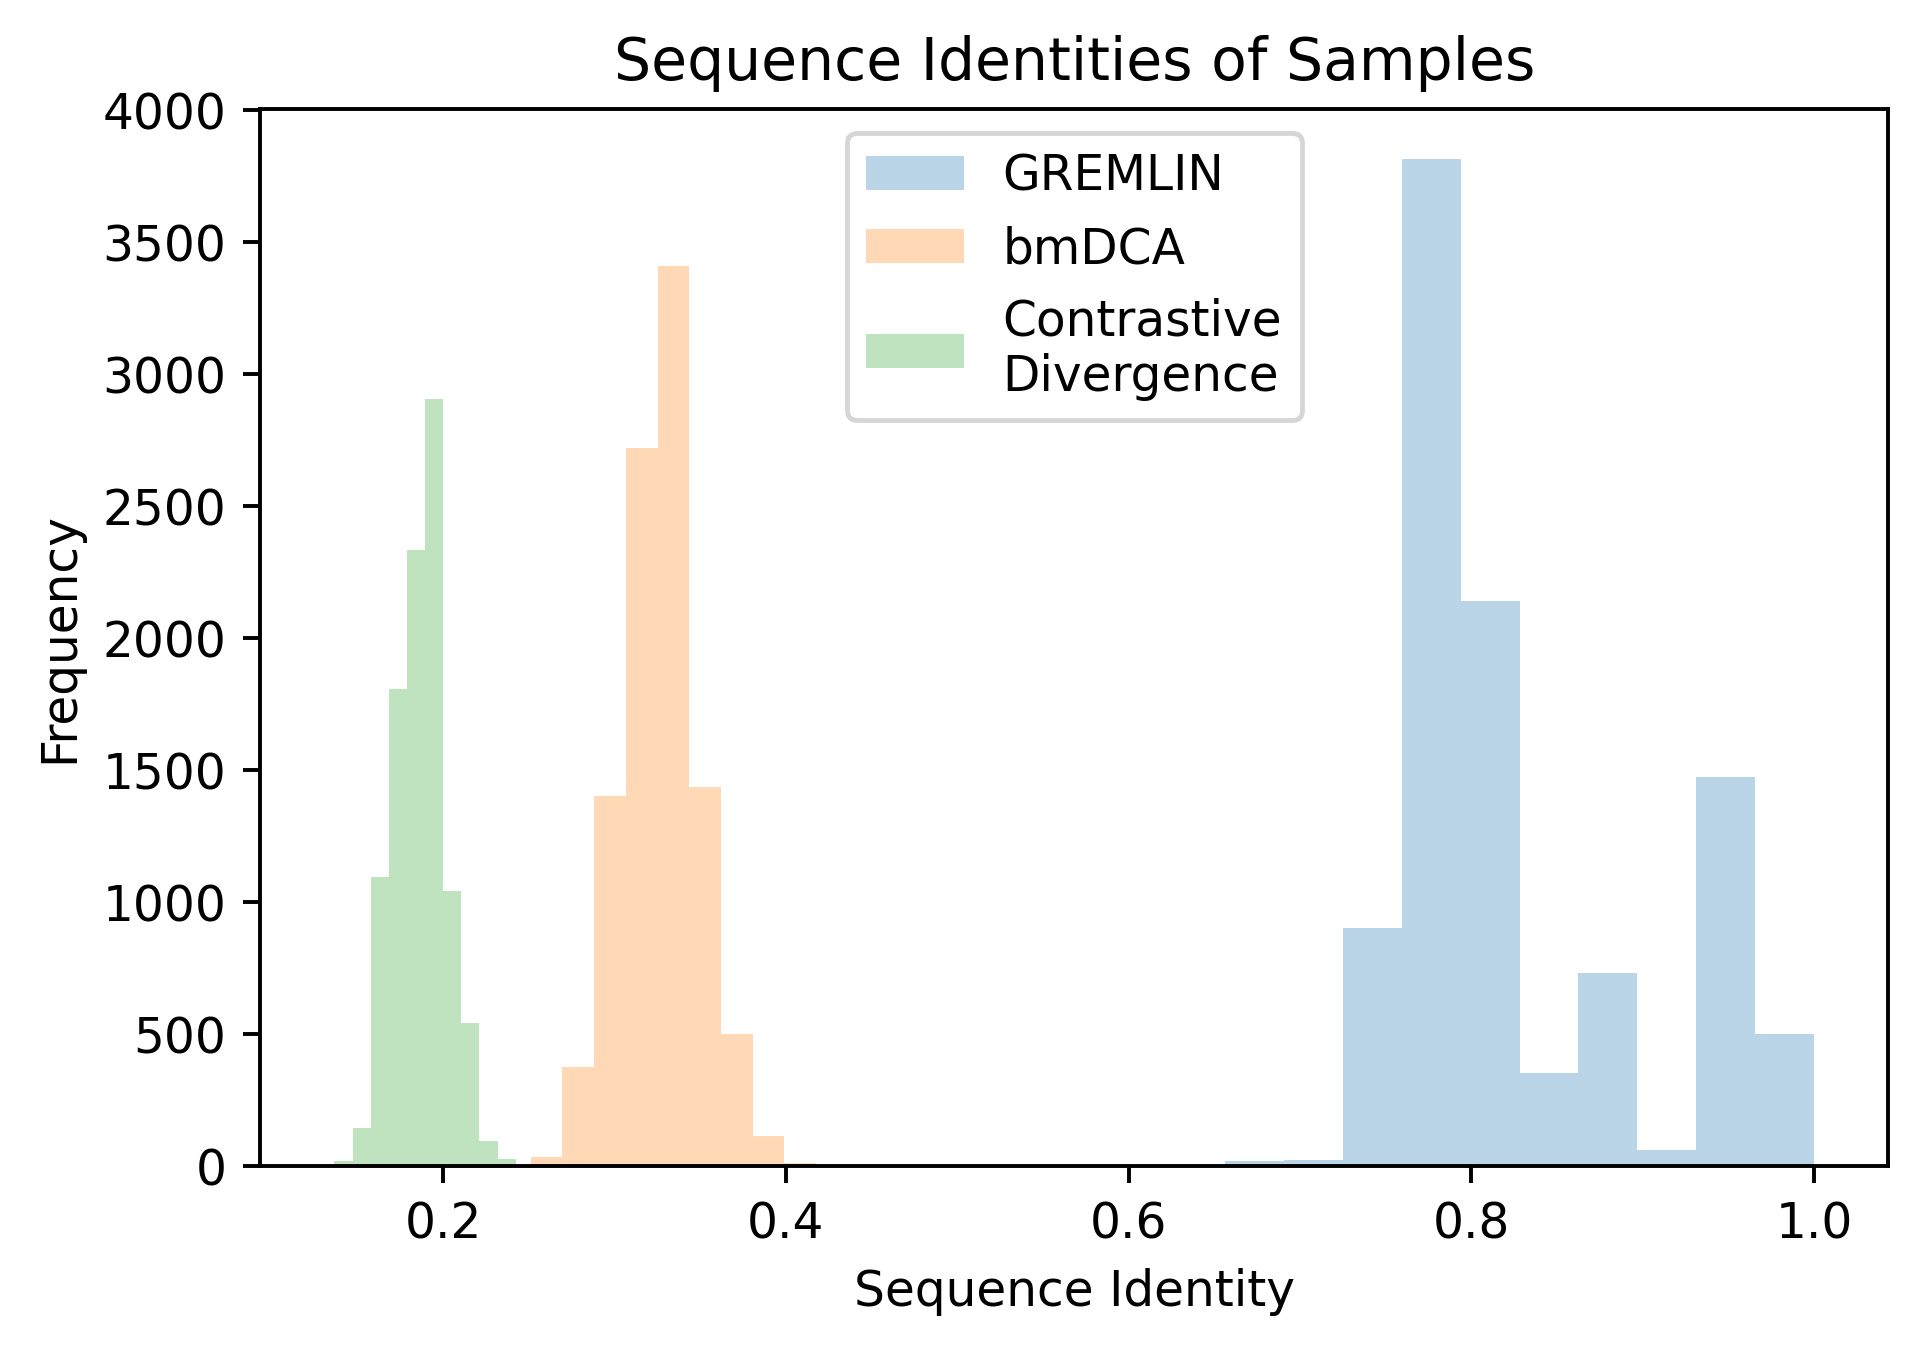

In [ ]:
plt.hist(idents_gremlin, alpha=0.3, label="GREMLIN")
plt.hist(idents_bmdca, alpha=0.3, label="bmDCA")
plt.hist(idents_contra, alpha=0.3, label="Contrastive\nDivergence")
plt.legend(loc="upper center")
plt.xlabel("Sequence Identity")
plt.ylabel("Frequency")
plt.title("Sequence Identities of Samples")
plt.show()

#### Sequence reweighing

In [ ]:
def train_potts(X_data, batch_size=64, epochs=200, lr=1e-4, L2=0.1):
    """
    X_data: Dataset object wrapping a list of sequences encoded as integers
    """
    
    train, test = train_test_split(list(range(len(X_data))), test_size=.2)

    train_loader = DataLoader(X_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(train))
    test_loader = DataLoader(X_data, batch_size=batch_size,
                          sampler=SubsetRandomSampler(test))

    potts_model = Potts().to(device)

    optimizer = torch.optim.Adam(potts_model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 1e-4, 1e-3, cycle_momentum=False)
    train_loss, test_loss = [], []

    for epoch in range(epochs):
        total_train_loss, total_test_loss = 0, 0        

        for Xin, w in tq.tqdm(train_loader):
            potts_model.train()
            optimizer.zero_grad()

            Xout = sample_from(potts_model, num_samples=batch_size)
            # print("computing loss")
            loss = loss_fn_weighted(potts_model, Xin, Xout, w, L2=L2)
            total_train_loss += loss.item()
            # print(loss.item())

            loss.backward()
            optimizer.step()

        train_loss.append(total_train_loss / len(train_loader))

        for Xin, w in test_loader:
            potts_model.eval()

            Xout = sample_from(potts_model, num_samples=batch_size)
            loss = loss_fn_weighted(potts_model, Xin, Xout, w, L2=L2)
            total_test_loss += loss.item()
            break
            
        test_loss.append(total_test_loss)
    torch.save(potts_model.state_dict(), "model.pt")
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.show()

    

In [ ]:
class SeqfuncData(Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y
        self.X = self.X.type(torch.FloatTensor)
        self.y = self.y.type(torch.FloatTensor)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_weights(x):
    """
    Reweighs the sequences to reduce the contribution of similar sequences
    to the gradient
    """
    x = x.to(device)
    bx, Lx = x.shape
    w = torch.zeros(bx).to(device)
    for i, s in enumerate(x):
        sims = 1 - torch.sum((x - s) != 0, dim=1) / Lx
        w[i] = 1 / torch.sum(sims >= 0.8)
    return w

In [ ]:
w = get_weights(in_dist)

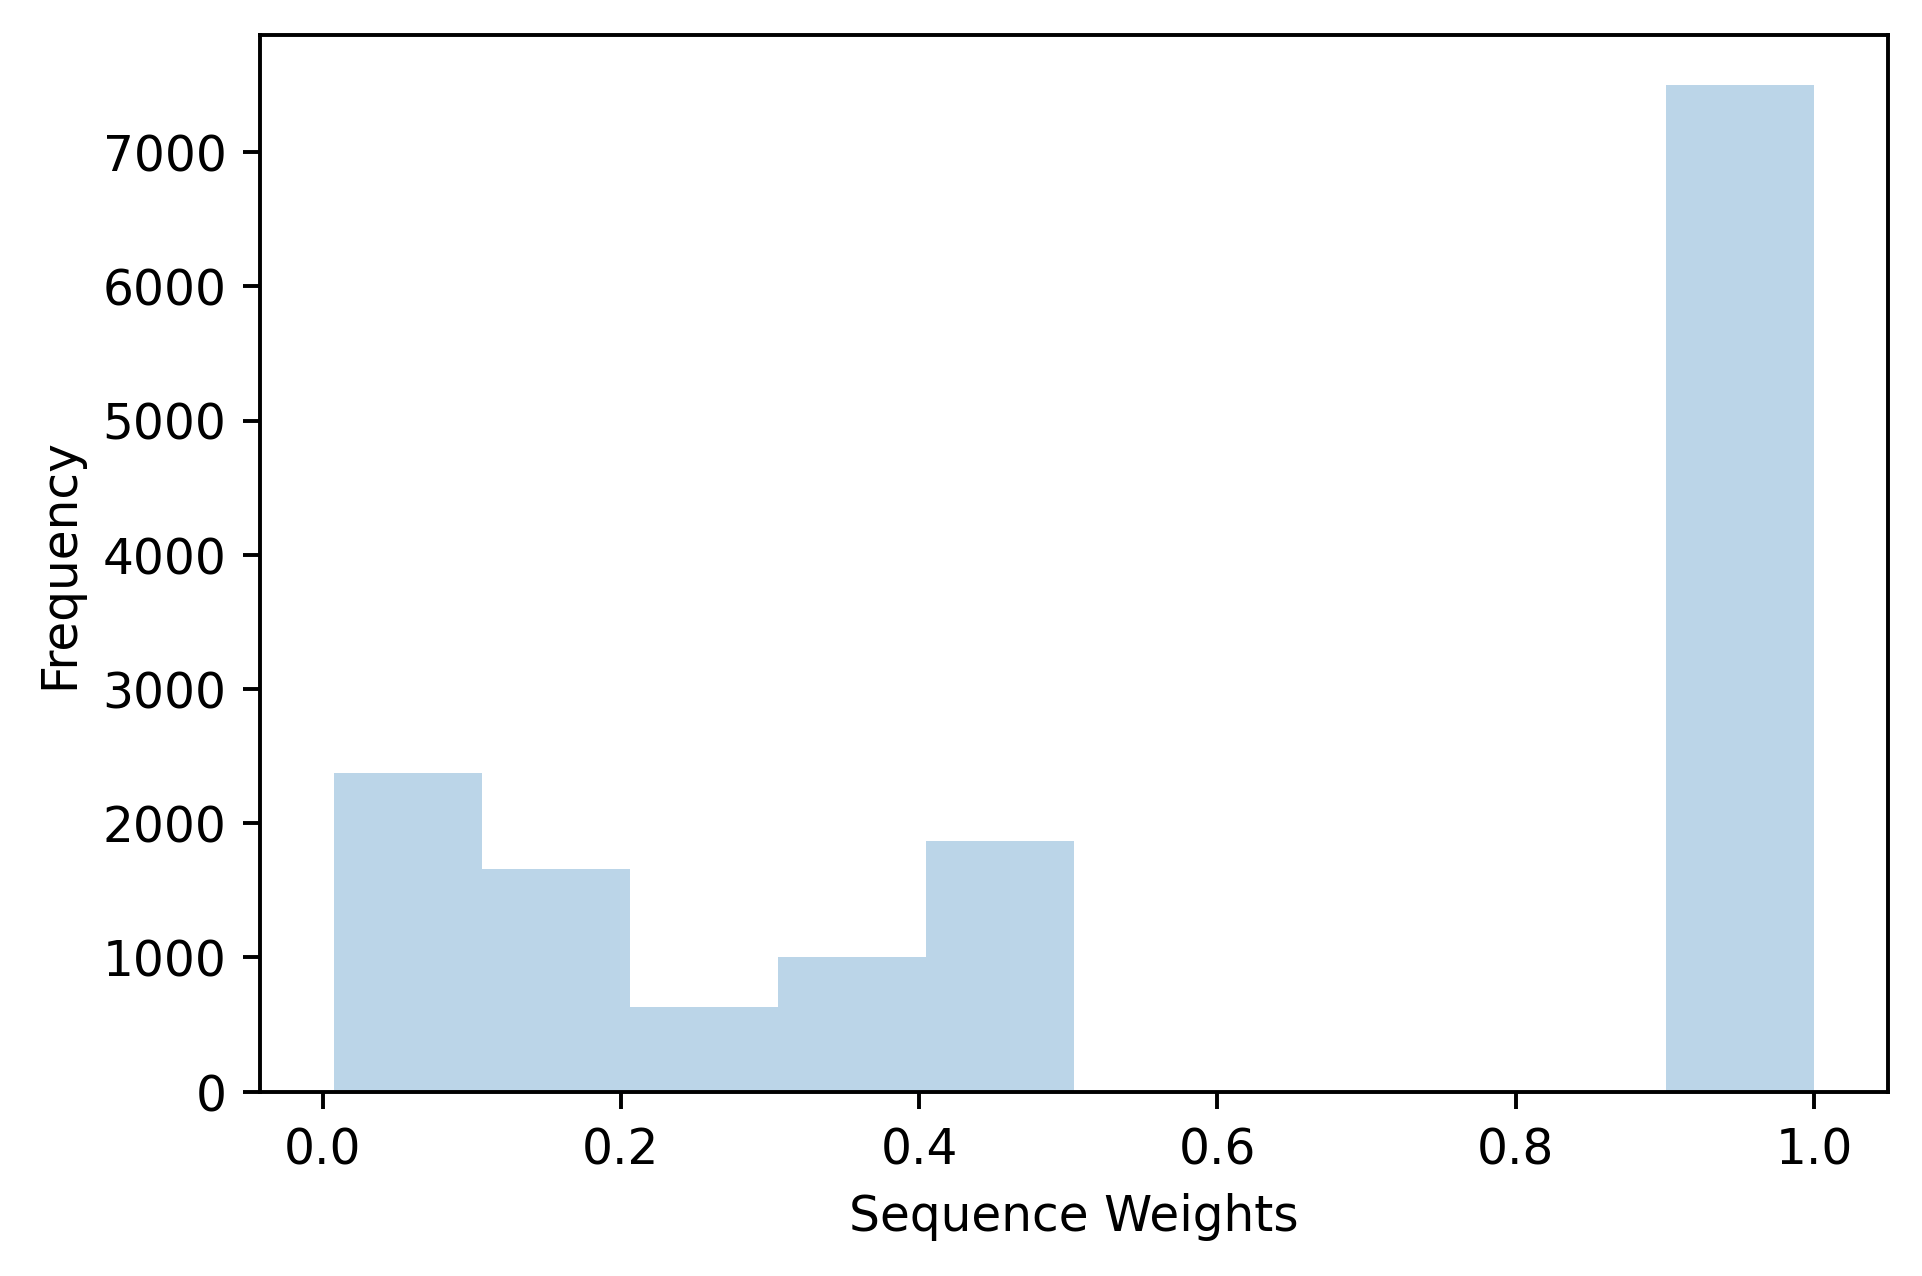

In [ ]:
plt.hist(w.cpu(), alpha=0.3)
plt.xlabel("Sequence Weights")
plt.ylabel("Frequency")
plt.show()

In [ ]:
X_data = SeqfuncData(in_dist, w)

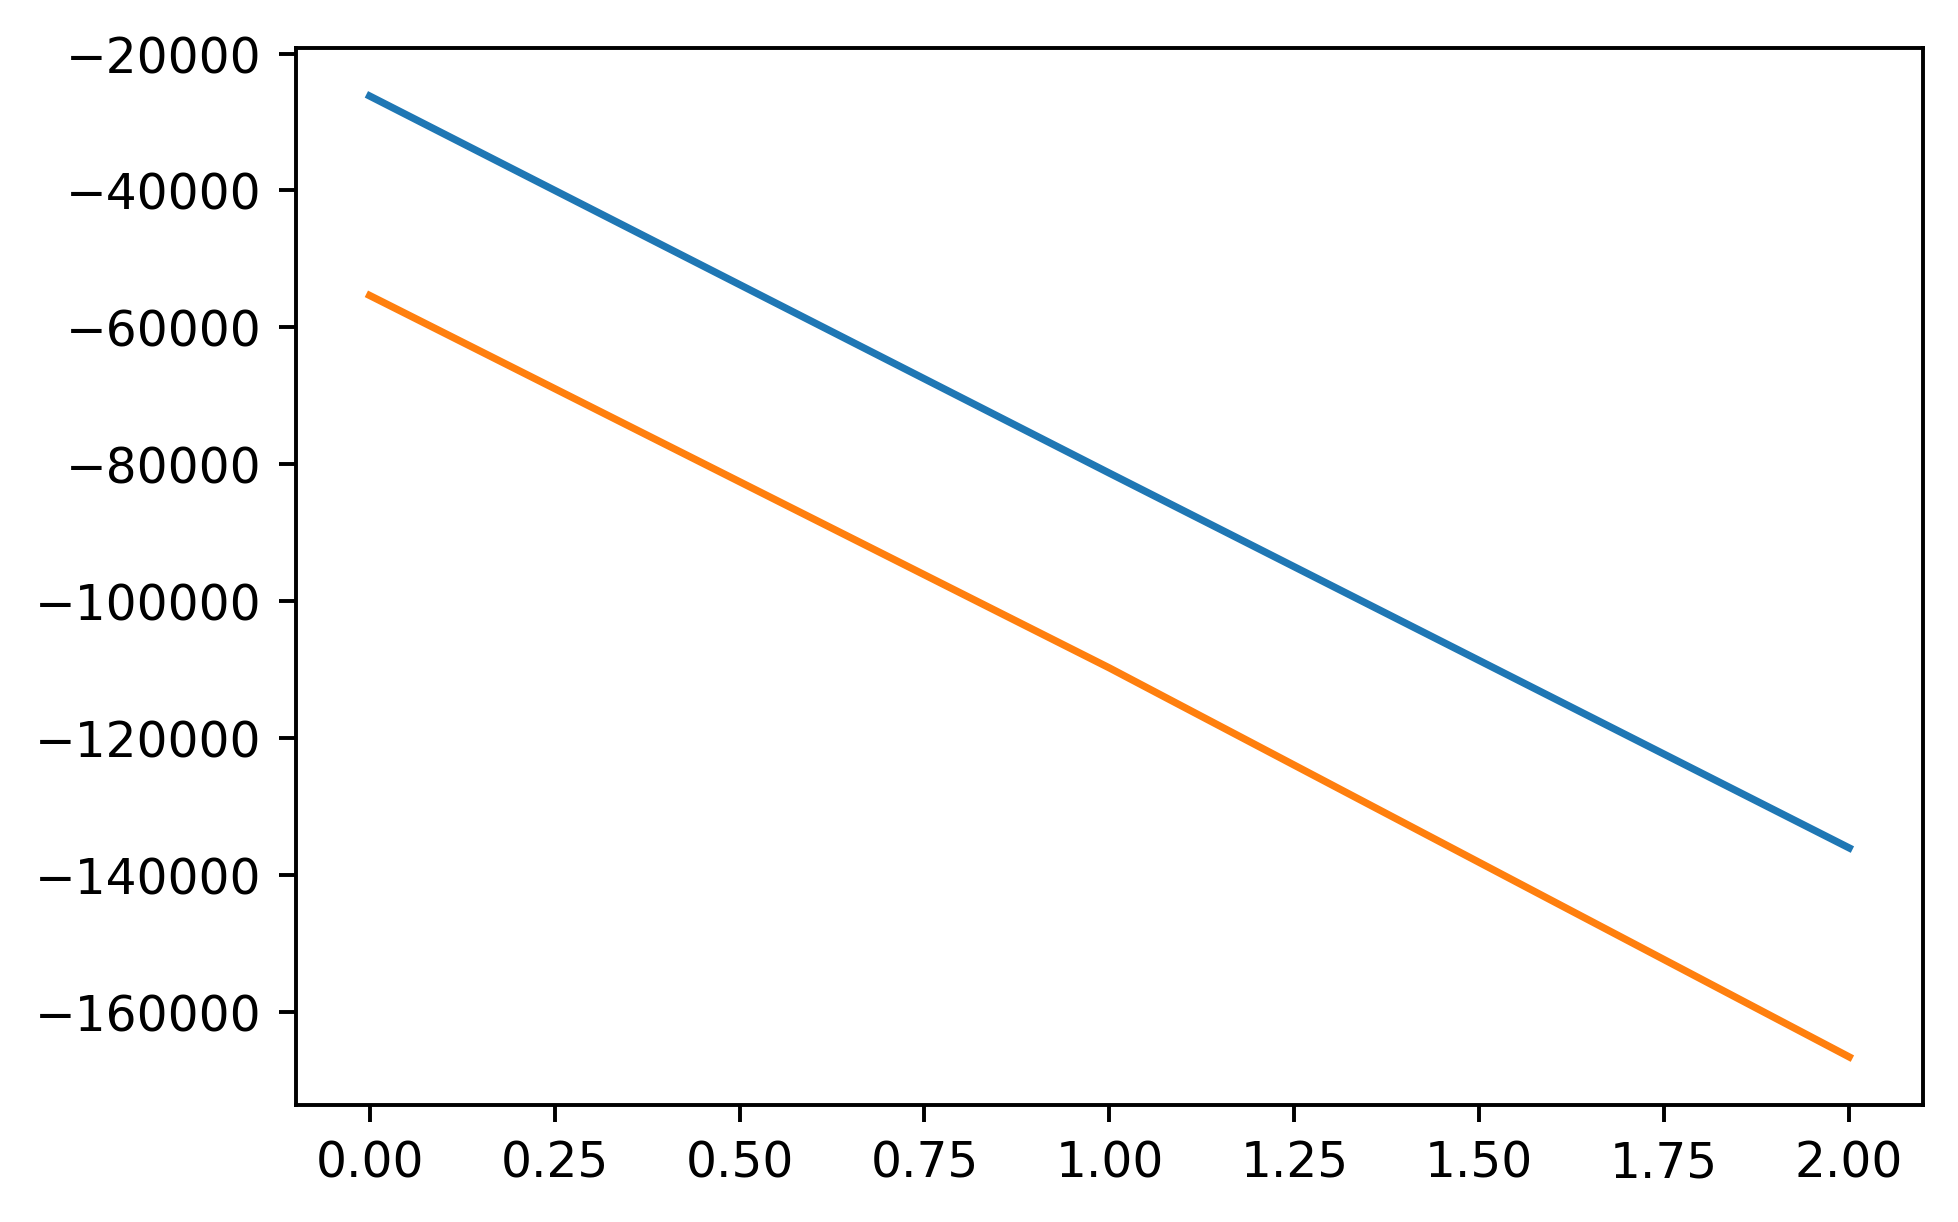

In [ ]:
train_potts(X_data, batch_size=512, epochs=3, L2=0.02)